In [1]:
# import libraries
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
import pickle 
import xarray as xr
import matplotlib.colors as colors
import seaborn as sns
import cmocean

# import some home-made functions
import nbimporter
from src.function_helpers import compute_flux_total, compute_flux_total_mean

# for mapping
import cartopy.crs as ccrs
# https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html
import cartopy.feature as cft
# BIG issue with cartopy: see here https://github.com/SciTools/cartopy/issues/1325 at @jypeter
# I had to download a bunch of stuff myself and put it in ~/.local/share/cartopy/shapefile/.../...
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
# https://scitools.org.uk/cartopy/docs/v0.15/examples/axes_grid_basic.html
land_110m = cft.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='gray', linewidth=0.5) # continents

# Extract and clean Henson's data

In [2]:
# Extract carbon export data
henson_data = scipy.io.loadmat('data/Henson/expHensonmod.mat')
latH = np.concatenate(henson_data['lat'])
lonH = np.concatenate(henson_data['lon'])
FexpH_raw = henson_data['exportC'] # units in gC/m2/year

# We need to add 8 latitudes points so that latH goes from -89.5 to 89.5
# otherwise the interpolation with Tim's grid will be translated downwards
add_latH = np.array([-82.5,-83.5,-84.5,-85.5,-86.5,-87.5,-88.5,-89.5])
latH = np.concatenate((latH, add_latH), axis = 0)

# Therefore, we need to add 8 blank lines in the Arctic region
add_blank = np.zeros((8,360))
add_blank[:] = np.NaN

# Cleaned carbon export (before interpolation on Tim's grid)
FexpH_raw = np.concatenate((FexpH_raw, add_blank))

# Extract primary production of Henson (ppH) et al., (2012)
ppHenson = scipy.io.loadmat('data/Henson/Figure4mats.mat')
ppH_raw = ppHenson['PP'] # units in gC m-2 year-1
ppH_raw = np.concatenate((ppH_raw, add_blank)) 
ppH_raw = np.concatenate((ppH_raw[:,100:], ppH_raw[:,:100]), axis = 1) # shift longitude 100° westwards

# export
epH_raw = ppHenson['EP'] # check units -> OK gC m-2 year-1
epH_raw = np.concatenate((epH_raw, add_blank)) 
epH_raw = np.concatenate((epH_raw[:,100:], epH_raw[:,:100]), axis = 1) # shift longitude 100° westwards

# Henson POC flux at 2000 m
Henson_2000m = ppHenson['POC2000']
Henson_2000m = np.concatenate((Henson_2000m, add_blank))
Henson_2000m = np.concatenate((Henson_2000m[:,100:], Henson_2000m[:,:100]), axis = 1)

# Attenuation factor *b* from Martin et al., (1987); Guidi et al., (2015) and Henson et al., (2012).

In [3]:
# load data
b_data = open("data/b_attenuation/b_data.pkl", "rb")
b_data = pickle.load(b_data)
b_martin = b_data['b_martin'] # b = 0.86
b_guidi = b_data['b_guidi'] # geographyically variable b
b_henson = b_data['b_henson'] # regionalized b

# Extract and clean Devries's data

In [4]:
tim_data = scipy.io.loadmat('data/Devries/F100.mat') 
f100 = tim_data['F100'] # # f100 (dimensionless) is the percentage of sequestered carbon
latT = np.concatenate(tim_data['lat'])
lonT = np.concatenate(tim_data['lon'])
depthT = np.concatenate(tim_data['depth']) # units = m

# Tim's longitude are eastward so from 0 to 360. I want -180 to 180 to fit my grid hence we do a bit translation.
f100 = np.concatenate((f100[:,90:,:], f100[:,:90,:]), axis = 1)
lonT = np.linspace(-179, 179, 180)

# replace 1 by 0 in Tim's first layer because it should not be 100% of sequestration at the surface (in his case, 4 meters).
f100[:,:,0] = np.where(f100[:,:,0] == 1 , 0, f100[:,:,0])

# Extract and clean SIMPLE TRIM's data

In [5]:
# open netcdf
#file = 'SIMPLE_TRIM_output.nc' # there was an error in that file
file = 'data/Devries/SIMPLE_TRIM_output_CORRECTED.nc'
with xr.open_dataset(file, engine='netcdf4') as ds:
    ds
    
# maskST = np.array(ds.mask[0,:,:]) # we don't use it
# maskST = np.transpose(maskST)
# maskST = np.concatenate((maskST[:,90:], maskST[:,:90]), axis = 1)
latST = np.array(ds.LAT[0,0,:])
lonST = np.array(ds.LON[0,:,0])
# it has been checked but lonST = lonT et latT = latST -> no need to interpolate, it's the same resolution
# lonST -180 == lonT
# latST == latT
depthST = np.array(ds.DEPTH[:,0,0])

# Euphotic depth
Zeu = ds.Zeu[0,:,:]
Zeu = np.transpose(np.array(Zeu))
Zeu = np.concatenate((Zeu[:,90:], Zeu[:,:90]), axis = 1) # Centered on Europe

# Export flux at 100m 
FexpT = ds.FPOC100m
FexpT = np.transpose(FexpT, [0,2,1]) * 12/1000 # transpose + convert mmolC/m2/year to gC/m2/year
FexpT = np.concatenate((FexpT[:,:,90:], FexpT[:,:,:90]), axis = 2) # center it on Europe

# Export flux at the euphotic depth
FexpZeu = ds.FPOCex 
FexpZeu = np.transpose(FexpZeu, [0,2,1]) * 12/1000
FexpZeu = np.concatenate((FexpZeu[:,:,90:], FexpZeu[:,:,:90]), axis = 2)

# Pixel area
pixelArea = np.transpose(np.array(ds.Area)) #m2

def transpose_translate_data(ds_data):
    """
    This function does an average of the input data then transpose and translate it.
    However, it does not work for all data in SIMPLE-TRIM (it needs 4 dimensions and needs to be checked before so be careful with that) 
    """
    data = np.transpose(ds_data, [0,3,2,1]) 
    data = np.concatenate((data[:,:,90:,:], data[:,:,:90,:]), axis = 2) 
    data = data * 12/1000 # conversion from mmolC to gC
    return(data)

# Dissolved organic carbon (DOC)
DOCl = transpose_translate_data(ds.DOCl)
DOCsl = transpose_translate_data(ds.DOCsl)
DOCsr = transpose_translate_data(ds.DOCsr)
DOCr = transpose_translate_data(ds.DOCr)

# DOC remineralization rates
kl = np.array(ds.k_L)
ksl = np.array(ds.k_SL)
ksr = np.array(ds.k_SR)
kr = np.array(ds.k_R)

# Particulate organic carbon (POC) fluxes
POCflux = transpose_translate_data(ds.POCflux)

# slow and fast POC
POCslow = transpose_translate_data(ds.POCslow)
POCfast = transpose_translate_data(ds.POCfast)
kslow = np.array(ds.gamma_S)
kfast = np.array(ds.gamma_F)

# doxy obs
o2_obs = np.array(ds.O2obs)
o2_obs = np.transpose(o2_obs, [2,1,0])
o2_obs = np.concatenate((o2_obs[:,90:,:], o2_obs[:,:90,:]), axis = 1) 

# kO2
Ko2 = np.array(ds.Ko2)

# Q10
q10 = np.array(ds.q10)

# T
Tref = 20 # see annexes
temp = np.array(ds.Temp)
temp = np.transpose(temp, [2,1,0])
temp = np.concatenate((temp[:,90:,:], temp[:,:90,:]), axis = 1) 

# NPP
ppST = ds.NPP
ppST = np.transpose(ppST, [0,2,1]) * 12/1000
ppST = np.concatenate((ppST[:,:,90:], ppST[:,:,:90]), axis = 2)

# Add sediment data

In [6]:
# add Fsedim based on Hayes et al., 2021. See also 02_compute_Fsedim.ipynb and 04_fill_missing_Hayes_pixels.R on RStudio 
Fsedim = np.load('data/Hayes/Fsedim.npy')

# Interpolation of f100 on the 24 depths of SIMPLE-TRIM

In [7]:
f100_ST = np.zeros((91,180,24)) # 24 depths in SIMPLE-TRIM

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) 
        tmp = f100[r,c,:]
        # interpolated f100
        f = interp1d(depthT, tmp)
        yvals = f(depthST)
        #yvals = np.interp(depthST, depthT, tmp) # works as well
        f100_ST[r,c,:] = yvals
        
# Sometimes, the interpolation does not go to the last depth of the profile.
# Hence, for those pixels, we put the last f100_ST to be the last f100
for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) 
        tmp = f100[r,c,:]
        #print(r,c)
        length_poc_flux = np.sum(~np.isnan(POCflux[0,r,c,])) 
        length_f100_ST = np.sum(~np.isnan(f100_ST[r,c,]))
        if (~np.isnan(tmp[0])) & (length_poc_flux != length_f100_ST):
            last_f100 = f100[r,c,~np.isnan(f100[r,c,])][-1]
            f100_ST[r,c,length_poc_flux-1] = last_f100
        
# # visual check 
# r = 40
# c = 40
# tmp = f100[r,c,:]
# # interpolated f100
# f = interp1d(depthT, tmp)
# xnew = depthST
# ynew = f(xnew)   # use interpolation function returned by `interp1d`
# #plt.plot(depthT, tmp, 'o', xnew, ynew, '-')
# plt.plot(depthT, tmp, 'o', xnew, f100_ST[r,c,:], 'x')
# plt.show()

# Computation of the deepest depth before reaching the sediment using Tim's data

In [8]:
# compute max depth before reaching the sediment
zmax = np.zeros(f100[:,:,0].shape)

# NOTE : I did not make the distinction between oceans and inland waters. However, f100 is only defined in 'ocean'
# waters so the problem goes away by itself. We should then see the 'ocean' points at depth < 100 m in white
# on the maps

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) 
        tmp = f100[r,c,:]
        if (all(np.isnan(tmp)) == False) & (np.isnan(np.sum(tmp))): # so we are not on a 'land' pixel or on a deep point (with data at 5581 m)
            index = np.argwhere(np.isnan(tmp))[0][0]
            zmax[r,c] = depthT[index-1]
        elif np.isnan(np.sum(tmp)) == False: # we are in the case of the 5581m layer
            zmax[r,c] = np.max(depthT)
        else:
            zmax[r,c] = np.nan

# mask pixels where Zmax < 100m
zmax_with_shallow_pixels = np.copy(zmax)
zmax = np.where(zmax<100, np.nan, zmax) 

# create mask
mask = np.where(zmax > 0.0, 1.0, zmax) # it masks the pixel < 100 m depth and some inland seas 
#mask = np.where(mask != 1.0, 0.0, mask) # was used to check if mask was equal to maskST -> yes

# check if previous step is ok
# np.argwhere(zmax == np.nanmax(zmax))
# np.argwhere(~np.isnan(f100[:,:,47]))

# ok it gives the same output

# new mask for data > 2000 m
mask_2000m = np.where(zmax<2000, np.nan, zmax)
mask_2000m = np.where(mask_2000m> 0.0, 1.0, mask_2000m)

# new mask for data > 1000 m
mask_1000m = np.where(zmax<1000, np.nan, zmax)
mask_1000m = np.where(mask_1000m> 0.0, 1.0, mask_1000m)

# # mask at 200m
# mask_200m = np.where(zmax<200, np.nan, zmax)
# mask_200m = np.where(mask_200m> 0.0, 1.0, mask_200m)

In [9]:
# I need to compute a matrix of deltaZ actually
deltaZ_matrix = np.zeros(POCflux[0,:,:,:].shape)
for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        tmp = POCflux[0,r,c,:] # index 0 for version but it does not matter here
        index_bottom = np.argmin(POCflux[0,r,c,:]) # give the index of the layer below the last layer
        deepest_depth = depthST[index_bottom-1]
        mask_pixel = mask[r,c]
        if np.isnan(mask_pixel): # land pixel ou < 100 m pixel
            deltaZ_matrix[r,c,:] = np.nan
        else:
            for k, depth in enumerate(depthST[:index_bottom]):
                if depth == depthST[0]: # case at the surface
                    deltaZ_matrix[r,c,k] = (depthST[k]+depthST[k+1])/2
                elif depth == deepest_depth: # case at the bottom
                    deltaZ_matrix[r,c,k] = deepest_depth - ((depthST[k-1]+deepest_depth)/2)
                    deltaZ_matrix[r,c,k+1:] = np.nan
                else:
                    deltaZ_matrix[r,c,k] = ((depthST[k]+depthST[k+1])/2) - ((depthST[k-1]+depthST[k])/2)

# Interpolate Henson's data on Tim's grid (coarser grid)

In [10]:
RlatH = latH[::-1] # reverse latH for ascending order needed by scipy

points = (RlatH, lonH)
values = FexpH_raw

RlatT = latT[::-1] 
RlonT = lonT[::-1]

FexpH = []
for i, lat in enumerate(RlatT):
    for j, lon in enumerate(lonT):
        point = np.array([lat,lon])
        try:
            tmp = float(interpn(points, values, point, method = 'nearest'))
            FexpH.append(tmp)
        except:
            tmp = np.nan
            FexpH.append(tmp)
            
FexpH = np.array(FexpH).reshape((91, 180)) # shape of f100 (Tim's data)      
# print(np.nanmax(FexpH))
# print(np.nanmean(FexpH))

# same for the primary production
# interpolate PP of Henson on Tim's grid
values = ppH_raw
values2 = epH_raw
values3 = Henson_2000m

ppH = []
epH = []
H2000 = []
for i, lat in enumerate(RlatT):
    for j, lon in enumerate(lonT):
        point = np.array([lat,lon])
        try:
            tmp = float(interpn(points, values, point, method = 'nearest'))
            ppH.append(tmp)
            tmp2 = float(interpn(points, values2, point, method = 'nearest'))
            epH.append(tmp2)
            tmp3 = float(interpn(points, values3, point, method = 'nearest'))
            H2000.append(tmp3)
        except:
            tmp = np.nan
            ppH.append(tmp)
            tmp2 = np.nan
            epH.append(tmp2)
            tmp3 = np.nan
            H2000.append(tmp3)
            
ppH = np.array(ppH).reshape((91, 180)) # shape of f100 (Tim's data)      
epH = np.array(epH).reshape((91, 180))
H2000 = np.array(H2000).reshape((91,180))

# Depth of export for Henson (100m)
ZexpH = np.zeros(ppH.shape)
ZexpH.fill(100) # Zexp for Henson is constant and fixed at 100m

# Check ppH with and without the <100m pixel mask

In [11]:
print(compute_flux_total(ppH, pixelArea)) 
print(compute_flux_total(ppH*mask, pixelArea)) 
ratioExpPP = epH/ppH
#plot_map((20,8), lonT, latT, ratioExpPP, 0, None, '', '', False, '', mask, cmap = "jet")
print(np.nanmean(ratioExpPP))

87.33501488130551
64.4200562104209
0.07670179318198936


In [12]:
# save data for Extended Figure 1 (ED1)
import pickle
figED1 = dict({'mask':mask, 'f100':f100, 'lon':lonT, 'lat':latT, 'depth':depthT})
file = open("data/output_data_for_figures/data_figED1.pkl", "wb")
pickle.dump(figED1, file)
file.close()

# Compute sequestration flux at 1000 and 2000 m

In [13]:
def compute_FseqPOC_1000m(b_matrix, Fexp_matrix, Zexp_matrix, POCflux, use_ST = False, latT = latT, lonT = lonT, zmax = zmax, depthST = depthST):
    
    FseqPOC_1000m = np.zeros(Fexp_matrix.shape)
    
    if use_ST == False:
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
                b = b_matrix[r,c] 
                Fexp = Fexp_matrix[r,c]
                Zexp = Zexp_matrix[r,c]
                if zmax_pixel >= 1000:
                    Flux_z = compute_FluxC(1000, b, Fexp, Zexp)
                    FseqPOC_1000m[r,c] = Flux_z # we assume that the flux at 2000 m is fully sequestered at that depth
                else:
                    FseqPOC_1000m[r,c] = np.nan
    else:
        # basic linear interp (at this depth, the flux is generally constant so basic linear interp is good
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                zmax_pixel = zmax[r,c]
                if zmax_pixel >= 1000: # pixel too shallow for sequestration above 2000m
                    slope = (POCflux[r,c,12] - POCflux[r,c,11])/(depthST[12] - depthST[11])
                    FseqPOC_1000m[r,c] = POCflux[r,c,11] + slope*(1000 - depthST[11]) # we assume that the flux at 1000 m is fully sequestered at that depth
                
    return(FseqPOC_1000m)

In [14]:
# Using Martin's law
def compute_FseqPOC_2000m(b_matrix, Fexp_matrix, Zexp_matrix, POCflux, use_ST = False, latT = latT, lonT = lonT, zmax = zmax, depthST = depthST):
    
    FseqPOC_2000m = np.zeros(Fexp_matrix.shape)
    
    if use_ST == False:
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
                b = b_matrix[r,c] 
                Fexp = Fexp_matrix[r,c]
                Zexp = Zexp_matrix[r,c]
                if zmax_pixel >= 2000:
                    Flux_z = compute_FluxC(2000, b, Fexp, Zexp)
                    FseqPOC_2000m[r,c] = Flux_z # we assume that the flux at 2000 m is fully sequestered at that depth
                else:
                    FseqPOC_2000m[r,c] = np.nan
    else:
        # basic linear interp (at this depth, the flux is generally constant so basic linear interp is good
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                zmax_pixel = zmax[r,c]
                if zmax_pixel >= 2000: # pixel too shallow for sequestration above 2000m
                    slope = (POCflux[r,c,16] - POCflux[r,c,15])/(depthST[16] - depthST[15])
                    FseqPOC_2000m[r,c] = POCflux[r,c,15] + slope*(2000 - depthST[15]) # we assume that the flux at 2000 m is fully sequestered at that depth
                
    return(FseqPOC_2000m)

# It is time to check if what we have done so far is OK

In [15]:
print(compute_flux_total_mean(FexpT, pixelArea)) # OK with what Tim found
print(compute_flux_total_mean(FexpZeu, pixelArea)) # OK with what Tim found
print(compute_flux_total(FexpH, pixelArea)) # OK with what Henson found

7.338796829045954
8.787427667716868
4.046082981596219


In [16]:
print(compute_flux_total_mean(FexpT*mask, pixelArea)) # OK with what Tim found
print(compute_flux_total_mean(FexpZeu*mask, pixelArea)) # OK with what Tim found
print(compute_flux_total(FexpH*mask, pixelArea)) # OK with what Henson found

7.334306930261694
8.576941277760994
3.0086205964406982


# Computation of the sequestered flux in Open Water

In [17]:
depthT # depth levels from Tim's data

array([4.93454087e+00, 1.48774788e+01, 2.51158413e+01, 3.59450532e+01,
       4.76605389e+01, 6.05577232e+01, 7.49320307e+01, 9.10788861e+01,
       1.09293714e+02, 1.29871939e+02, 1.53108986e+02, 1.79300279e+02,
       2.08741243e+02, 2.41727303e+02, 2.78553883e+02, 3.19516408e+02,
       3.64910303e+02, 4.15030992e+02, 4.70173900e+02, 5.30634451e+02,
       5.96708071e+02, 6.68690183e+02, 7.46876213e+02, 8.31561585e+02,
       9.23041723e+02, 1.02161205e+03, 1.12756800e+03, 1.24120499e+03,
       1.36281844e+03, 1.49270378e+03, 1.63115644e+03, 1.77847183e+03,
       1.93494539e+03, 2.10087254e+03, 2.27654870e+03, 2.46226930e+03,
       2.65832976e+03, 2.86502551e+03, 3.08265197e+03, 3.31150457e+03,
       3.55187872e+03, 3.80406987e+03, 4.06837342e+03, 4.34508481e+03,
       4.63449945e+03, 4.93691279e+03, 5.25262023e+03, 5.58191720e+03])

In [18]:
def compute_Fseq_water(z1, z2, b, f_100, Fexp, Zexp):
    """
    For sequestration in open waters
    
    INPUTS : z1, z2 : depths above and below depth of interest
             b : Martin's coefficient (but can be a one different from Martin like Guidi's one or Henson's one)
             f_100 : % of captured carbon
             Fexp : flux of exported carbon 
             Zexp : depth of export 
    OUTPUT : Fseq : the flux of sequestered carbon
    """
    
    if (np.isnan(b)) | (np.isnan(f_100)) | (np.isnan(Fexp)):
        Fseq = np.nan
        Fremin = np.nan
    elif z1 == 0: # because raising 0 to a power raises an error
        Fremin = Fexp * (0-((z2/Zexp)**b))
        Fseq = Fremin * f_100
    else:
        Fremin = Fexp * ((z1/Zexp)**b - ((z2/Zexp)**b)) # delta_flux = Fremin(pixel, depth)
        Fseq = Fremin * f_100 # units gC m-2 year-1
    return(Fremin, Fseq)

In [19]:
def compute_sequestration_in_water(zmax_matrix, depthX, b_matrix, f100_matrix, Fexp_matrix, Zexp_matrix, Fsedim = Fsedim, latT = latT, lonT = lonT):
    
    """
    For computing the sequestration flux in open water
    INPUTS : latT, lonT : arrays of discrete latitudes and longitudes
             zmax_matrix : array of maximum depth per pixel before reaching the sediment
             depthX : array of depth layers
             b_matrix : array of b values per pixel
             f100_matrix : array of f100 values per pixel 
             Fexp_matrix : array of export flux per pixel
             Zexp_matrix : array of depth of export per pixel
    OUTPUT : Fseq_water : the sequestered carbon in open water
    """
    
    # compute the sequestration flux in open water
    # The special case of surface and zmax(pixel) is taken into account.
    
    Fseq_water = np.zeros(f100_matrix.shape) # this will be for the 3D Fseq in open water, units in gC m-2 year-1
    Fremin_water = np.zeros(f100_matrix.shape)
    FseqDeep = np.zeros(zmax_matrix.shape)
    FseqDeepestOrg = np.zeros(zmax_matrix.shape) # needed to compare FseqDeepestOrg with Fsedim later

    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) # c for column
            zmax_pixel = zmax_matrix[r,c] # deepest depth of that pixel before reaching the sediment
            # NOTE: depending on the version of zmax (with or without shallow (<100m) pixels, there is no need to apply the mask here) =============> WELL THAT IS NOT TRUE, IF WE USE ALL PIXELS, THEN WE NEED TO ADD THAT THERE IS NO SEQUESTRATION IN THE WATER FOR ZMAX(PIXELS) < 100m
            b = b_matrix[r,c] # for the paper, we'll only use Martin's b. Maybe Lionel's or Henson's for supp. material
            Fexp = Fexp_matrix[r,c]
            Zexp = Zexp_matrix[r,c]
            FPOC_sedim = Fsedim[r,c]
            for k, depth in enumerate(depthX):
                f100_z = f100_matrix[r,c,k]
                if np.isnan(zmax_pixel): # land pixel
                    Fseq_water[r,c,:] = np.nan
                    Fremin_water[r,c,:] = np.nan
                    FseqDeep[r,c] = np.nan
                    FseqDeepestOrg[r,c] = np.nan
                    break
                elif depth == np.min(depthX): # special case at the surface
                    z1 = 0
                    z2 = (depthX[k]+depthX[k+1])/2
                    Fremin_z, Fseq_z = compute_Fseq_water(z1, z2, b, f100_z, Fexp, Zexp) # z for Fseq at that particular depth z
                    Fseq_water[r,c,k] = Fseq_z
                    Fremin_water[r,c,k] = Fremin_z
                elif depth == zmax_pixel: # special case at the deepest depth (before reaching sediments)
                    z1 = (depthX[k-1]+zmax_pixel)/2
                    z2 = zmax_pixel
                    Fremin_z, Fseq_z = compute_Fseq_water(z1, z2, b, f100_z, Fexp, Zexp) 
                    Fseq_water[r,c,k] = Fseq_z
                    Fremin_water[r,c,k] = Fremin_z
                    FseqDeep[r,c] = ((Fexp * (z2/Zexp)**b) - FPOC_sedim) * f100_z
                    FseqDeepestOrg[r,c] = Fexp * (z2/Zexp)**b
                    if(zmax_pixel != np.max(depthX)): # we reached the zmax of that pixel so all values below should be nan
                        Fseq_water[r,c,k+1:] = np.nan
                        Fremin_water[r,c,k+1:] = np.nan
                        break # go to next lat/lon point
                else:
                    z1 = (depthX[k-1]+depthX[k])/2
                    z2 = (depthX[k]+depthX[k+1])/2
                    Fremin_z, Fseq_z = compute_Fseq_water(z1, z2, b, f100_z, Fexp, Zexp) 
                    Fseq_water[r,c,k] = Fseq_z
                    Fremin_water[r,c,k] = Fremin_z
    
    return(Fremin_water, Fseq_water, FseqDeep, FseqDeepestOrg)

# Just a reminder to check loops/functions if needed

In [20]:
# land point
r = 0
c = 0

In [21]:
# deepest point (deepest depth reaches 5581 m)
r = 57
c = 59

In [22]:
# normal open water point (not reaching the last depth of 5581 m)
r = 40
c = 40

# Focus on f100

In [23]:
# compute weighted mean f100 below Zeu

weighted_mean_f100 = np.zeros(f100[:,:,0].shape) # only for layers below Zeu

for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        Zeu_pixel = Zeu[r,c]
        zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
        f100_wm = [] # f100 weighted mean (wm)
        deltaz_pixel = [] 
        n_layers_above_Zeu = len(depthT[depthT < Zeu_pixel])
        for k, depth in enumerate(depthT):
            if np.isnan(zmax_pixel): # land pixel
                weighted_mean_f100[r,c] = np.nan
            elif depth == np.min(depthT): # case at the surface
                deltaz = (depthT[k]+depthT[k+1])/2
                deltaz_pixel.append(deltaz)
                f100_wm.append(f100[r,c,k] * deltaz)
            elif depth == zmax_pixel: # case at zmax_pixel
                deltaz = zmax_pixel - ((zmax_pixel+depthT[k-1])/2)
                deltaz_pixel.append(deltaz)
                f100_wm.append(f100[r,c,k] * deltaz)
                # compute weighted mean here, at zmax
                weighted_mean_f100[r,c] = (1/np.sum(np.array(deltaz_pixel[n_layers_above_Zeu+1:])))*np.sum(np.array(f100_wm[n_layers_above_Zeu+1:]))
                break
            else:
                deltaz = ((depthT[k]+depthT[k+1])/2) - ((depthT[k-1]+depthT[k])/2)
                deltaz_pixel.append(deltaz)
                f100_wm.append(f100[r,c,k] * deltaz)

In [24]:
# compute some stats on weighted mean f100
print(np.nanmax(weighted_mean_f100)) 
print(np.nanmedian(weighted_mean_f100)) 
print(np.nanmean(weighted_mean_f100))
print(np.nanmin(weighted_mean_f100))

0.9708453380521918
0.7231108464522966
0.6840619342252362
0.0


In [25]:
# check pixels where weighted mean f100 is above median
f100_weighted_above_median = np.copy(weighted_mean_f100)
f100_weighted_above_median = np.where(f100_weighted_above_median < np.nanmedian(weighted_mean_f100), np.nan, f100_weighted_above_median)

In [26]:
# compute regions in and outside the median
f100_weighted_lines = np.zeros(weighted_mean_f100.shape)
f100_weighted_lines = np.where(f100_weighted_above_median > 0.0, 1.0, f100_weighted_lines)

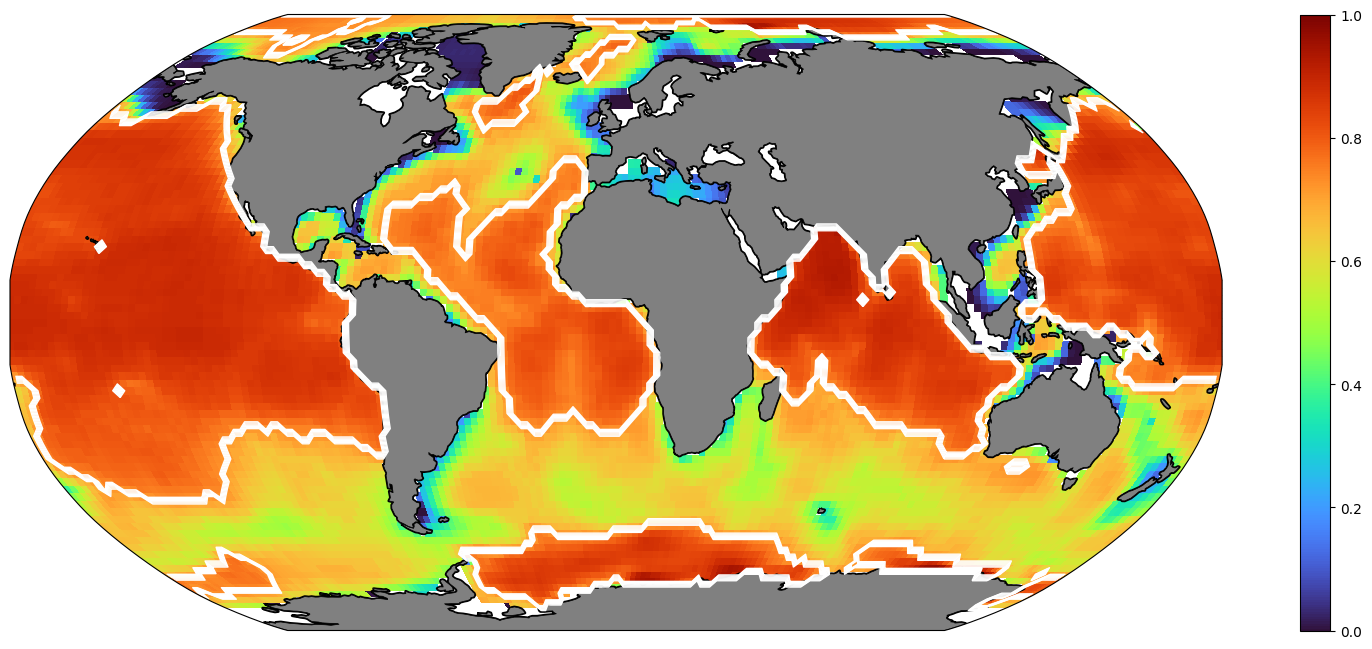

In [27]:
# plot it
fig, ax = plt.subplots(1,1,figsize=(20,8),subplot_kw={'projection': ccrs.Robinson()})
ax.coastlines(resolution='110m', color='black', linestyle='-', alpha=1, linewidth = 2)
# p = ax.contourf(lonT, latT, weighted_mean_f100, shading = 'auto', 
#                  transform = ccrs.PlateCarree(), vmin = 0, vmax = 1)
p = ax.pcolormesh(lonT, latT, weighted_mean_f100, shading = 'auto', 
                 transform = ccrs.PlateCarree(), vmin = 0, vmax = 1, cmap = 'turbo')
color_map = plt.cm.get_cmap('turbo')
reversed_color_map = color_map.reversed()
# p = ax.pcolormesh(lonT, latT, weighted_mean_f100, shading = 'auto', 
#                  transform = ccrs.PlateCarree(), vmin = 0, vmax = 1, cmap = reversed_color_map)
ax.contour(lonT, latT, f100_weighted_lines, vmin = np.nanmedian(weighted_mean_f100),
                 transform = ccrs.PlateCarree(), colors = 'white', linewidths = 1)
ax.add_feature(land_110m)
#ax.set_title('Weighted mean f100')
cbar = plt.colorbar(p)
#cbar.set_label('[%]')
plt.show()

# Computation of the sequestered DOC flux based on SIMPLE-TRIM data

In [28]:
def add_matrix(A,B):
    """
    Function that deals with the issue of matrix addition with NaN (np.nansum(np.nan) == 0)
    This could potentially bias some average so it is important to be cautious when adding arrays with NaN.
    """
    matrix = np.where(np.isnan(A), B, A + np.nan_to_num(B))  
    return(matrix)

In [29]:
def compute_FseqDOC_ST(use_Zeu, DOCl, kl, DOCsl, ksl, DOCsr, ksr, DOCr, kr, latT = latT, lonT = lonT, f100_ST = f100_ST, deltaZ = deltaZ_matrix):

    FreminDOC = DOCl * kl * deltaZ # labile DOC, gC  m-2 y-1
    FreminDOC = add_matrix(FreminDOC, DOCsl * ksl * deltaZ) # semi-labile DOC, gC m-2 y-1
    FreminDOC = add_matrix(FreminDOC, DOCsr * ksr * deltaZ) # semi-refractory DOC, gC m-2 y-1
    FreminDOC = add_matrix(FreminDOC, DOCr * kr * deltaZ) # refractory DOC, gC m-2 y-1
    FseqDOC_ST = f100_ST * FreminDOC
 
    if use_Zeu == False: # Zexp = 100
        print('...not using Zeu...')
        FseqDOC_ST2 = np.nansum(FseqDOC_ST[:,:,3:], axis = 2)
        FseqDOC_ST2 = np.where(FseqDOC_ST2 == 0.0, np.nan, FseqDOC_ST2)
        
    else:
        print('...using Zeu...')
        Fseq_pixel = np.zeros(Zeu.shape)
        Fremin_pixel = np.zeros(Zeu.shape)
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                Zeu_pixel = Zeu[r,c] # Euphotic depth for a pixel
                index_depth = np.argmax(Zeu_pixel - depthST < 0)
                Fseq_pixel[r,c] = np.nansum(FseqDOC_ST[r,c,index_depth:])
                FseqDOC_ST2 = np.where(Fseq_pixel == 0.0, np.nan, Fseq_pixel) 
                
    # in any case, Zexp = 100 m or Zexp = Zeu
    Fseq_below_2000m = np.nansum(FseqDOC_ST[:,:,16:], axis = 2)
    Fseq_below_2000m = np.where(Fseq_below_2000m == 0.0, np.nan, Fseq_below_2000m) 
    
    # 1000 m
    Fseq_below_1000m = np.nansum(FseqDOC_ST[:,:,12:], axis = 2)
    Fseq_below_1000m = np.where(Fseq_below_1000m == 0.0, np.nan, Fseq_below_1000m) 
    
    return(FreminDOC, FseqDOC_ST, FseqDOC_ST2, Fseq_below_2000m, Fseq_below_1000m)

# Computation of FseqPOC using modeled carbon fluxes from SIMPLE-TRIM

In [30]:
JreminPOC_slow = np.zeros((12,91,180,24))
for v in range(12):
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) 
            for k, depth in enumerate(depthST):
                JreminPOC_slow[v,r,c,k] = (kslow[v]*(q10[v]**((temp[r,c,k]-Tref)/10)))*(o2_obs[r,c,k]/(o2_obs[r,c,k]+Ko2[v]))*POCslow[v,r,c,k]

JreminPOC_fast = np.zeros((12,91,180,24))
for v in range(12):
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) 
            for k, depth in enumerate(depthST):
                JreminPOC_fast[v,r,c,k] = (kfast[v]*(q10[v]**((temp[r,c,k]-Tref)/10)))*(o2_obs[r,c,k]/(o2_obs[r,c,k]+Ko2[v]))*POCfast[v,r,c,k]

In [31]:
def compute_FseqPOC_ST(use_Zeu, version, latT = latT, lonT = lonT, f100_ST = f100_ST, Fsedim = Fsedim, depthST = depthST, JreminPOC_slow = JreminPOC_slow, JreminPOC_fast = JreminPOC_fast, deltaZ = deltaZ_matrix):
    
    FreminPOC_slow = JreminPOC_slow[version,:,:,:] * deltaZ # gC m-2 y-1
    FreminPOC_fast = JreminPOC_fast[version,:,:,:] * deltaZ # gC m-2 y-1
    FreminPOC = add_matrix(FreminPOC_slow, FreminPOC_fast) # gC m-2 y-1
    FseqPOC_ST = FreminPOC * f100_ST # gC m-2 y-1 
    
    # remove sediment flux from FseqPOC(water)
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) # c for column
            index_last_depth = np.where(np.isnan(FseqPOC_ST[r,c,:]))[0][0]-1
            Fsed_pixel = Fsedim[r,c]
            FseqPOC_ST[r,c,index_last_depth] = ((FseqPOC_ST[r,c,index_last_depth]/f100_ST[r,c,index_last_depth]) - Fsed_pixel) * f100_ST[r,c,index_last_depth]
    
    if use_Zeu == False: # Zexp = 100
        print('...not using Zeu...')
        FseqPOC_ST2 = np.nansum(FseqPOC_ST[:,:,3:], axis = 2)
        FseqPOC_ST2 = np.where(FseqPOC_ST2 == 0.0, np.nan, FseqPOC_ST2)
        
    else:
        print('...using Zeu...')
        Fseq_pixel = np.zeros(Zeu.shape)
        Fremin_pixel = np.zeros(Zeu.shape)
        for i, lat in enumerate(latT):
            for j, lon in enumerate(lonT):
                r = int(np.array(np.where(latT == lat))) # r for row
                c = int(np.array(np.where(lonT == lon))) # c for column
                Zeu_pixel = Zeu[r,c] # Euphotic depth for a pixel
                index_depth = np.argmax(Zeu_pixel - depthST < 0)
                Fseq_pixel[r,c] = np.nansum(FseqPOC_ST[r,c,index_depth:])
                FseqPOC_ST2 = np.where(Fseq_pixel == 0.0, np.nan, Fseq_pixel) 
    
    # in any case, Zexp = 100 m or Zexp = Zeu
    Fseq_below_2000m = np.nansum(FseqPOC_ST[:,:,16:], axis = 2)
    Fseq_below_2000m = np.where(Fseq_below_2000m == 0.0, np.nan, Fseq_below_2000m) 
    
    # Fseq below 1000 m
    Fseq_below_1000m = np.nansum(FseqPOC_ST[:,:,12:], axis = 2)
    Fseq_below_1000m = np.where(Fseq_below_1000m == 0.0, np.nan, Fseq_below_1000m) 
    
    return(FreminPOC, FseqPOC_ST, FseqPOC_ST2, Fseq_below_2000m, Fseq_below_1000m)

In [32]:
# test
i = 0
a,b,c,d,e = compute_FseqPOC_ST(False, i)
compute_flux_total(c, pixelArea)
#compute_flux_total(d, pixelArea)

...not using Zeu...


<ipython-input-31-064fcdef8fa6>:15: RuntimeWarning: invalid value encountered in double_scalars
  FseqPOC_ST[r,c,index_last_depth] = ((FseqPOC_ST[r,c,index_last_depth]/f100_ST[r,c,index_last_depth]) - Fsed_pixel) * f100_ST[r,c,index_last_depth]


1.8891221232956976

# Computation of FseqMigr

# Daily

In [33]:
# compute North Atlantic Mask /!\ TO BE IMPROVED (with more precise coordinates)
mask_index = []
maskNorthAtl = np.zeros(FexpH.shape)

lat_Jonasdottir = np.argwhere((latT >= 55) & (latT <= 70)) 
lon_Jonasdottir = np.argwhere((lonT >= -60) & (lonT <= 10))

for i in lat_Jonasdottir:
    for j in lon_Jonasdottir:
        tmp = (int(i),int(j))
        mask_index.append(tmp)
        
# compute mask
for coord in mask_index:
    maskNorthAtl[coord] = 1.0

maskNorthAtl = np.where(maskNorthAtl != 1.0, np.nan, maskNorthAtl)

In [34]:
def compute_FmigrD(Fexp_matrix, f100 = f100):
    # daily migration
    FreminMigrD = 0.25 * Fexp_matrix
    FseqMigrD = FreminMigrD * f100[:,:,15]
    
    return(FreminMigrD, FseqMigrD)

# Seasonally 

In [35]:
def compute_FluxC(z, b, Fexp, Zexp):
    Flux = Fexp * (z/Zexp)**b 
    return(Flux)

In [36]:
def compute_Fseq_migr_seasonal(b_matrix, Fexp_matrix, Zexp_matrix, POCflux, use_ST = False, latT = latT, lonT = lonT, mask = maskNorthAtl, zmax = zmax, depthT = depthT, f100 = f100):
    
    Flux_migr_season = np.zeros(Fexp_matrix.shape)
    
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) # c for column
            zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
            b = b_matrix[r,c] # for the paper, we'll only use this. Maybe Lionel's or Henson's for supp. material
            Fexp = Fexp_matrix[r,c]
            Zexp = Zexp_matrix[r,c]
            depth = depthT[20]
            if np.isnan(zmax_pixel): # land pixel
                Flux_migr_season[r,c] = np.nan
            elif depth >= zmax_pixel: # shallow pixel for seasonal migration flux
                Flux_migr_season[r,c] = np.nan
            else:
                if use_ST == False:
                    Flux_z = compute_FluxC(depth, b, Fexp, Zexp)
                    Flux_migr_season[r,c] = Flux_z
                else:
                    Flux_z = POCflux[r,c,9] # 619m
                    Flux_migr_season[r,c] = Flux_z
        
    Fremin = 0.5 * Flux_migr_season * mask
    Fseq = Fremin * f100[:,:,20]
    
    return(Fremin, Fseq)

# Compute FexpDOC based on ST DOC fluxes

In [37]:
def compute_FexpDOC(DOCl, DOCsl, DOCsr, DOCr, FexpT, depthST = depthST, FexpH = FexpH, deltaZ = deltaZ_matrix, pixelArea = pixelArea):
    
    FluxDOC = DOCl  # first, the labile DOC
    FluxDOC = add_matrix(FluxDOC, DOCsl) # add semi-labile DOC
    FluxDOC = add_matrix(FluxDOC, DOCsr) # add semi-refractory DOC
    FluxDOC = add_matrix(FluxDOC, DOCr) # add refractory DOC
    
    # Fexp(S-T, Zexp = 100m) # technically we are at 115m
    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon)))
            FexpDOC_ST = FluxDOC[r,c,4] * deltaZ[r,c,4] 
    
    # FexpDOC_Henson
    ratio_export_global = compute_flux_total(FexpH, pixelArea)/compute_flux_total(FexpT, pixelArea)

    FexpDOC_H = FexpDOC_ST * ratio_export_global
    
    return(FexpDOC_H, FexpDOC_ST)

# OLD WAY TO COMPUTE FseqDOC

In [38]:
def compute_FseqDOC_v1(Fexp, f100_matrix):
#def compute_FseqDOC_pixel(coarser_export, pc_co2, f100_surface_layer):
    
    FreminDOC = 0.25 * Fexp
    FseqDOC = FreminDOC * f100_matrix[:,:,19]
    
    return(FseqDOC)

# RESULTS

In [39]:
def printResult(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, FseqSedim, pixel_areas, mask):
    
    print('Global Fseq(POC):', np.round(compute_flux_total(FseqPOC*mask, pixel_areas),2), ' GtC/year'),
    print('Global Fseq(DOC):', np.round(compute_flux_total(FseqDOC*mask, pixel_areas),2), ' GtC/year')
    print('Global Fseq(Migr Diel):', np.round(compute_flux_total(FseqMigrD*mask, pixel_areas),2), ' GtC/year')
    print('Global Fseq(Migr Season):', np.round(compute_flux_total(FseqMigrS*mask, pixel_areas),3), ' GtC/year')
    print('Global Fseq(Sediment):', np.round(compute_flux_total(FseqSedim*mask, pixel_areas),2), ' GtC/year')
    print('Global BCPs:', np.sum(np.array([np.round(compute_flux_total(FseqPOC*mask, pixel_areas),2),
                                np.round(compute_flux_total(FseqDOC*mask, pixel_areas),2),
                                np.round(compute_flux_total(FseqMigrD*mask, pixel_areas),2),
                                np.round(compute_flux_total(FseqMigrS*mask, pixel_areas),2)])), 'GtC/year')

In [40]:
def printResult_mean_median(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, FseqSedim, pixel_areas, mask):
    
    totalBCP = add_matrix(FseqPOC, FseqDOC)
    totalBCP = add_matrix(totalBCP, FseqMigrD)
    totalBCP = add_matrix(totalBCP, FseqMigrS)
    
    print('MEDIAN VALUES')
    print('Median Fseq(POC):', np.round(np.nanmedian(FseqPOC*mask),2), ' gC/m2/year'),
    print('Median Fseq(DOC):', np.round(np.nanmedian(FseqDOC*mask),2), ' gC/m2/year')
    print('Median Fseq(Migr Diel):', np.round(np.nanmedian(FseqMigrD*mask),2), ' gC/m2/year')
    print('Median Fseq(Migr Season):', np.round(np.nanmedian(FseqMigrS*mask),2), ' gC/m2/year')
    print('Median BCPs:', np.round(np.nanmedian(totalBCP*mask),2), 'gC/m2/year')
    print('Median Fseq(Sediment)', np.round(np.nanmedian(FseqSedim*mask),2), 'gC/m2/year')
    print('\nMEAN VALUES')
    print('Mean Fseq(POC):', np.round(np.nanmean(FseqPOC*mask),2), ' gC/m2/year'),
    print('Mean Fseq(DOC):', np.round(np.nanmean(FseqDOC*mask),2), ' gC/m2/year')
    print('Mean Fseq(Migr Diel):', np.round(np.nanmean(FseqMigrD*mask),2), ' gC/m2/year')
    print('Mean Fseq(Migr Season):', np.round(np.nanmean(FseqMigrS*mask),2), ' gC/m2/year')
    print('Mean BCPs:', np.round(np.nanmean(totalBCP*mask),2), 'gC/m2/year')
    print('Mean Fseq(Sediment)', np.round(np.nanmean(FseqSedim*mask),2), 'gC/m2/year')
    
    return(totalBCP)

In [41]:
def printResult_ratio_reference(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, pixel_areas, mask, FexpReference, use_ST = False, Fsedim = Fsedim):
    
    if use_ST == False:
        reference = compute_flux_total(FexpReference*mask, pixel_areas)
    else:
        reference = compute_flux_total_mean(FexpReference*mask, pixel_areas) # WE WILL USE THE MASK ALSO FOR HENSON # no mask because FexpH ~ 4GtC/year and it's a kind of reference (if we use the mask, we would have ~3.3-3.4 PgC y-1)
    
    print('Global Fexp:', np.round(reference, 2), 'GtC/year')
    print('Global F*seq(POC):', np.round(compute_flux_total(FseqPOC*mask, pixel_areas)/reference,2))
    print('Global F*seqBCPs:', np.round(np.sum(np.array([compute_flux_total(FseqPOC*mask, pixel_areas),
                                compute_flux_total(FseqDOC*mask, pixel_areas),
                                compute_flux_total(FseqMigrD*mask, pixel_areas),
                                compute_flux_total(FseqMigrS*mask, pixel_areas)]))/reference,2))
    print('Global F*seq(sedim):', np.round(compute_flux_total(Fsedim*mask, pixel_areas)/reference,3))

In [42]:
def compute_pixel_area(pixel_area, data, mask):
    map_data = data*mask # masked data with mask of > 100m 
    total_pixel_number = map_data.shape[0]*map_data.shape[1] # total number of pixels (resolution in fine)
    pixel_defined = ~np.isnan(map_data)
    number_pixel_defined = np.sum(~np.isnan(map_data))
    covered_area = np.sum(pixelArea[pixel_defined])/1e12 # km2
    
    return(number_pixel_defined, covered_area)

In [43]:
def compute_pixel_area_version(FseqPOC, FseqDOC, FseqMigrD, FseqMigrS, FseqBCPs, FseqPOC2000, FseqSedim, pixelArea, mask):
    print('FseqPOC pixel + area:', compute_pixel_area(pixelArea, FseqPOC, mask))
    print('FseqDOC pixel + area:', compute_pixel_area(pixelArea, FseqDOC, mask))
    print('FseqMigrD pixel + area:', compute_pixel_area(pixelArea, FseqMigrD, mask))
    print('FseqMigrS pixel + area:', compute_pixel_area(pixelArea, FseqMigrS, mask))
    print('FseqBCPs pixel + area:', compute_pixel_area(pixelArea, FseqBCPs, mask))
    print('Fseq2000m pixel + area:', compute_pixel_area(pixelArea, FseqPOC2000, mask))
    print('FseqSedim pixel + area:', compute_pixel_area(pixelArea, FseqSedim, mask))

In [44]:
def compute_min_max_median_FreminMigrS(FreminMigrS):
    min_val = np.nanmin(FreminMigrS)
    max_val = np.nanmax(FreminMigrS)
    median_val = np.nanmedian(FreminMigrS)
    return(min_val, max_val, median_val)

# CONVERSE VERSION 7 (C7)

## with Fexp = Fexp from Henson and Zexp = 100 m

In [45]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m, FseqDeep_H_100m, FseqDeepestOrg_C7 = compute_sequestration_in_water(zmax, depthT, b_martin, f100, FexpH, ZexpH)
#FseqDeep_C7 = FseqDeep_H_100m # for later comparison between sequestration in the deepest water layer and in the sediment
FseqDeep_H_100m = FseqDeep_H_100m[:,:,np.newaxis] 
FseqPOC_H_100m = np.nansum(np.concatenate((FseqPOC_H_water_100m[:,:,8:], FseqDeep_H_100m), axis = 2), axis = 2)
FseqPOC_H_100m = np.where(FseqPOC_H_100m == 0.0, np.nan, FseqPOC_H_100m)

# POC below 2000 m
FseqPOC_H_below_2000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_2000m = np.nansum(FseqPOC_H_below_2000m[:,:,33:], axis = 2) * mask_2000m
FseqPOC_H_below_2000m = np.where(FseqPOC_H_below_2000m == 0.0, np.nan, FseqPOC_H_below_2000m)

# POC below 1000 m
FseqPOC_H_below_1000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_1000m = np.nansum(FseqPOC_H_below_1000m[:,:,25:], axis = 2) * mask_1000m
FseqPOC_H_below_1000m = np.where(FseqPOC_H_below_1000m == 0.0, np.nan, FseqPOC_H_below_1000m)

# compute_flux_total(FseqPOC_H_below_2000m*mask, pixelArea)

# DOC below Top - v1
FseqDOC_H_100m = compute_FseqDOC_v1(FexpH, f100) # old version for table S2

# Migration Daily
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# compute FexpDOC
FexpDOC_H_100m = np.zeros((12,91,180))
FexpDOC_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FexpDOC_H_100m[i,:,:], FexpDOC_ST_100m[i,:,:] = compute_FexpDOC(DOCl[i,:,:,:], DOCsl[i,:,:,:], DOCsr[i,:,:,:], DOCr[i,:,:,:], FexpT[i,:,:])
# average
FexpDOC_H_100m = np.nanmean(FexpDOC_H_100m, axis = 0)

# Fseq(2000m)
FseqPOC2000m_martin = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_martin[i,:,:] = compute_FseqPOC_2000m(b_martin, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)

# Fseq(1000m)
FseqPOC1000m_martin = np.zeros((12,91,180))
for i in range(12):
    FseqPOC1000m_martin[i,:,:] = compute_FseqPOC_1000m(b_martin, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC1000m_martin = np.nanmean(FseqPOC1000m_martin, axis = 0)

# save data for plot
FseqPOC_H_100m_C7 = FseqPOC_H_100m
FseqDOC_H_100m_C7 = FseqDOC_H_100m
FseqMigrD_H_100m_C7 = FseqMigrD_H_100m
FseqMigrS_H_100m_C7 = FseqMigrS_H_100m

<ipython-input-45-c7faf0d2a55f>:32: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-45-c7faf0d2a55f>:33: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)
<ipython-input-45-c7faf0d2a55f>:41: RuntimeWarning: Mean of empty slice
  FexpDOC_H_100m = np.nanmean(FexpDOC_H_100m, axis = 0)
<ipython-input-45-c7faf0d2a55f>:47: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)
<ipython-input-45-c7faf0d2a55f>:53: RuntimeWarning: Mean of empty slice
  FseqPOC1000m_martin = np.nanmean(FseqPOC1000m_martin, axis = 0)


In [46]:
# print results
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask) # note : Fsedim = FseqSdim cause 100% is then sequestered in the sediment
print('')
# with ratio reference
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask)
FseqBCPs_H_100m_C7 = FseqBCPs_H_100m
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea), 2))
print('\nSequestration flux at 1000 m:', np.round(compute_flux_total(FseqPOC1000m_martin*mask, pixelArea), 2))
ref = compute_flux_total(FexpH*mask, pixelArea)

## 2000 m
print('\nF*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea)/ref, 2))
print('FseqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_H_below_2000m*mask, pixelArea), 2))
print('F*seqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_H_below_2000m*mask, pixelArea)/ref, 2))

## 1000 m
print('\nF*seq(1000):', np.round(compute_flux_total(FseqPOC1000m_martin*mask, pixelArea)/ref, 2))
print('FseqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_H_below_1000m*mask, pixelArea), 2))
print('F*seqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_H_below_1000m*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FreminMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

Global Fseq(POC): 0.63  GtC/year
Global Fseq(DOC): 0.22  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Sediment): 0.03  GtC/year
Global BCPs: 0.96 GtC/year

Global Fexp: 3.01 GtC/year
Global F*seq(POC): 0.21
Global F*seqBCPs: 0.32
Global F*seq(sedim): 0.008

MEDIAN VALUES
Median Fseq(POC): 1.53  gC/m2/year
Median Fseq(DOC): 0.49  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 1.02  gC/m2/year
Median BCPs: 2.25 gC/m2/year
Median Fseq(Sediment) 0.05 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 1.99  gC/m2/year
Mean Fseq(DOC): 0.68  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.93  gC/m2/year
Mean BCPs: 3.02 gC/m2/year
Mean Fseq(Sediment) 0.08 gC/m2/year

Sequestration flux at 2000 m: 0.19

Sequestration flux at 1000 m: 0.38

F*seq(2000): 0.06
FseqPOC(>2000m) 0.15
F*seqPOC(>2000m) 0.05

F*seq(1000): 0.13
FseqPOC(>1000m) 0.31
F*seqPOC(>1000m) 0.1

Values min/max/median for Fremin

In [47]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqBCPs_H_100m, FseqPOC2000m_martin, Fsedim, pixelArea, mask)

FseqPOC pixel + area: (9202, 343.02957342925237)
FseqDOC pixel + area: (8931, 336.8577215110956)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqBCPs pixel + area: (9208, 343.124110162332)
Fseq2000m pixel + area: (7952, 308.33030463063744)
FseqSedim pixel + area: (10339, 353.172816305548)


# CONVERSE VERSION 5 (C5)

## with Fexp= FexpTim (i.e. SIMPLE_TRIM) and Zexp = 100 m

In [48]:
# POC below Zexp (Top)
FreminPOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_100m = np.zeros((12,91,180))
FseqPOC_ST_below_2000m = np.zeros((12,91,180))
FseqPOC_ST_below_1000m = np.zeros((12,91,180))
for i in range(12):
    FreminPOC_ST_100m_full_matrix[i,:,:,:], FseqPOC_ST_100m_full_matrix[i,:,:,:], FseqPOC_ST_100m[i,:,:], FseqPOC_ST_below_2000m[i,:,:], FseqPOC_ST_below_1000m[i,:,:] = compute_FseqPOC_ST(False, i)
FseqPOC_ST_100m = np.nanmean(FseqPOC_ST_100m, axis = 0)
FseqPOC_ST_below_2000m = np.nanmean(FseqPOC_ST_below_2000m, axis = 0)
FseqPOC_ST_below_1000m = np.nanmean(FseqPOC_ST_below_1000m, axis = 0)

# DOC
FreminDOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_100m_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_100m = np.zeros((12,91,180))
FseqDOC_ST_below_2000m = np.zeros((12,91,180))
FseqDOC_ST_below_1000m = np.zeros((12,91,180))
for i in range(12):
    FreminDOC_ST_100m_full_matrix[i,:,:,:], FseqDOC_ST_100m_full_matrix[i,:,:,:], FseqDOC_ST_100m[i,:,:], FseqDOC_ST_below_2000m[i,:,:], FseqDOC_ST_below_1000m[i,:,:] = compute_FseqDOC_ST(False, DOCl[i,:,:,:], kl[i], DOCsl[i,:,:,:], ksl[i], DOCsr[i,:,:,:], ksr[i], DOCr[i,:,:,:], kr[i])
FseqDOC_ST_100m = np.nanmean(FseqDOC_ST_100m, axis = 0)
FseqDOC_ST_below_2000m = np.nanmean(FseqDOC_ST_below_2000m, axis = 0)
FseqDOC_ST_below_1000m = np.nanmean(FseqDOC_ST_below_1000m, axis = 0)

# Migration D
FreminMigrD_ST_100m = np.zeros((12,91,180))
FseqMigrD_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrD_ST_100m[i,:,:], FseqMigrD_ST_100m[i,:,:] = compute_FmigrD(FexpT[i,:,:])
FreminMigrD_ST_100m = np.nanmean(FreminMigrD_ST_100m, axis = 0)
FseqMigrD_ST_100m = np.nanmean(FseqMigrD_ST_100m, axis = 0)

# Migration Seasonally
FreminMigrS_ST_100m = np.zeros((12,91,180))
FseqMigrS_ST_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_ST_100m[i,:,:], FseqMigrS_ST_100m[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], True)
FreminMigrS_ST_100m = np.nanmean(FreminMigrS_ST_100m, axis = 0)
FseqMigrS_ST_100m = np.nanmean(FseqMigrS_ST_100m, axis = 0)

# Fseq(2000)
FseqPOC2000m_ST = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_ST[i,:,:] = compute_FseqPOC_2000m(b_guidi, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], use_ST = True) # in that case, we only need use_ST, actually...
FseqPOC2000m_ST = np.nanmean(FseqPOC2000m_ST, axis = 0)

# Fseq(1000)
FseqPOC1000m_ST = np.zeros((12,91,180))
for i in range(12):
    FseqPOC1000m_ST[i,:,:] = compute_FseqPOC_1000m(b_guidi, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], use_ST = True) # in that case, we only need use_ST, actually...
FseqPOC1000m_ST = np.nanmean(FseqPOC1000m_ST, axis = 0)

# Fremin in deepest depth layer
FseqDeepestOrg_C5 = np.zeros((Fsedim.shape))
for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        index_last_depth = np.where(np.isnan(FseqPOC_ST_100m_full_matrix[1,r,c,]))[0][0]-1 
        #FseqDeep_C5[r,c] = np.mean(FseqPOC_ST_100m_full_matrix[:,r,c,index_last_depth])
        FseqDeepestOrg_C5[r,c] = ((np.mean(FseqPOC_ST_100m_full_matrix[:,r,c,index_last_depth]))/f100_ST[r,c,index_last_depth]+Fsedim[r,c])#*f100_ST[r,c,index_last_depth]

<ipython-input-31-064fcdef8fa6>:15: RuntimeWarning: invalid value encountered in double_scalars
  FseqPOC_ST[r,c,index_last_depth] = ((FseqPOC_ST[r,c,index_last_depth]/f100_ST[r,c,index_last_depth]) - Fsed_pixel) * f100_ST[r,c,index_last_depth]


...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...


<ipython-input-48-3e1934dbf791>:9: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_100m = np.nanmean(FseqPOC_ST_100m, axis = 0)
<ipython-input-48-3e1934dbf791>:10: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_below_2000m = np.nanmean(FseqPOC_ST_below_2000m, axis = 0)
<ipython-input-48-3e1934dbf791>:11: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_below_1000m = np.nanmean(FseqPOC_ST_below_1000m, axis = 0)


...not using Zeu...
...not using Zeu...
...not using Zeu...
...not using Zeu...


<ipython-input-48-3e1934dbf791>:21: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_100m = np.nanmean(FseqDOC_ST_100m, axis = 0)
<ipython-input-48-3e1934dbf791>:22: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_below_2000m = np.nanmean(FseqDOC_ST_below_2000m, axis = 0)
<ipython-input-48-3e1934dbf791>:23: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_below_1000m = np.nanmean(FseqDOC_ST_below_1000m, axis = 0)
<ipython-input-48-3e1934dbf791>:30: RuntimeWarning: Mean of empty slice
  FreminMigrD_ST_100m = np.nanmean(FreminMigrD_ST_100m, axis = 0)
<ipython-input-48-3e1934dbf791>:31: RuntimeWarning: Mean of empty slice
  FseqMigrD_ST_100m = np.nanmean(FseqMigrD_ST_100m, axis = 0)
<ipython-input-48-3e1934dbf791>:38: RuntimeWarning: Mean of empty slice
  FreminMigrS_ST_100m = np.nanmean(FreminMigrS_ST_100m, axis = 0)
<ipython-input-48-3e1934dbf791>:39: RuntimeWarning: Mean of empty slice
  FseqMigrS_ST_100m = np.nanmean(FseqMigrS_ST_100m, axis = 0)
<ipython-input-48-3e1934dbf791>:45: Ru

In [49]:
# print results
printResult(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, Fsedim, pixelArea, mask)
# print results
print('')
printResult_ratio_reference(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, pixelArea, mask, FexpT, use_ST = True)
print('')
FseqBCPs_ST_100m = printResult_mean_median(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, Fsedim, pixelArea, mask)

print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea), 2))
print('\nSequestration flux at 1000 m:', np.round(compute_flux_total(FseqPOC1000m_ST*mask, pixelArea), 2))

## 2000 m
ref = compute_flux_total_mean(FexpT*mask, pixelArea)
print('\nF*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea)/ref, 2))
print('FseqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_ST_below_2000m*mask, pixelArea), 2))
print('F*seqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_ST_below_2000m*mask, pixelArea)/ref, 2))
print('FseqDOC(>2000m)', np.round(compute_flux_total(FseqDOC_ST_below_2000m*mask, pixelArea), 2))
print('F*seqDOC(>2000m)', np.round(compute_flux_total(FseqDOC_ST_below_2000m*mask, pixelArea)/ref, 2))
FseqBCP_below_2000m = add_matrix(FseqPOC_ST_below_2000m, FseqDOC_ST_below_2000m)
print('\nFseqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea), 2))
print('F*seqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea)/ref, 2))

## 1000 m
print('\nF*seq(1000):', np.round(compute_flux_total(FseqPOC1000m_ST*mask, pixelArea)/ref, 2))
print('FseqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_ST_below_1000m*mask, pixelArea), 2))
print('F*seqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_ST_below_1000m*mask, pixelArea)/ref, 2))
print('FseqDOC(>1000m)', np.round(compute_flux_total(FseqDOC_ST_below_1000m*mask, pixelArea), 2))
print('F*seqDOC(>1000m)', np.round(compute_flux_total(FseqDOC_ST_below_1000m*mask, pixelArea)/ref, 2))
FseqBCP_below_1000m = add_matrix(FseqPOC_ST_below_1000m, FseqDOC_ST_below_1000m)
print('\nFseqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea), 2))
print('F*seqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_ST_100m)
print('\nValues min/max/median for FreminMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

Global Fseq(POC): 1.86  GtC/year
Global Fseq(DOC): 0.31  GtC/year
Global Fseq(Migr Diel): 0.26  GtC/year
Global Fseq(Migr Season): 0.01  GtC/year
Global Fseq(Sediment): 0.03  GtC/year
Global BCPs: 2.4399999999999995 GtC/year

Global Fexp: 7.33 GtC/year
Global F*seq(POC): 0.25
Global F*seqBCPs: 0.33
Global F*seq(sedim): 0.003

MEDIAN VALUES
Median Fseq(POC): 4.17  gC/m2/year
Median Fseq(DOC): 0.43  gC/m2/year
Median Fseq(Migr Diel): 0.47  gC/m2/year
Median Fseq(Migr Season): 2.35  gC/m2/year
Median BCPs: 5.55 gC/m2/year
Median Fseq(Sediment) 0.05 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 5.16  gC/m2/year
Mean Fseq(DOC): 1.21  gC/m2/year
Mean Fseq(Migr Diel): 0.77  gC/m2/year
Mean Fseq(Migr Season): 2.25  gC/m2/year
Mean BCPs: 7.18 gC/m2/year
Mean Fseq(Sediment) 0.08 gC/m2/year

Sequestration flux at 2000 m: 0.47

Sequestration flux at 1000 m: 1.13

F*seq(2000): 0.06
FseqPOC(>2000m) 0.28
F*seqPOC(>2000m) 0.04
FseqDOC(>2000m) 0.03
F*seqDOC(>2000m) 0.0

FseqBCP(>2000m) 0.31
F*seqBCP(>2000m) 

In [50]:
compute_pixel_area_version(FseqPOC_ST_100m, FseqDOC_ST_100m, FseqMigrD_ST_100m, FseqMigrS_ST_100m, FseqBCPs_ST_100m, FseqPOC2000m_ST, Fsedim, pixelArea, mask)

FseqPOC pixel + area: (10276, 351.7488109020153)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (10139, 349.0908936396123)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqBCPs pixel + area: (10285, 351.91521347399987)
Fseq2000m pixel + area: (10288, 351.830549404102)
FseqSedim pixel + area: (10339, 353.172816305548)


# CONVERSE VERSION 4 (C4)

## with Fexp= FexpTim (i.e. SIMPLE_TRIM) and Zexp = Zeu

In [51]:
# POC below Zexp (Top)
FreminPOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqPOC_ST_Zeu = np.zeros((12,91,180))
FseqPOC_ST_below_2000m = np.zeros((12,91,180))
FseqPOC_ST_below_1000m = np.zeros((12,91,180))
for i in range(12):
    FreminPOC_ST_Zeu_full_matrix[i,:,:,:], FseqPOC_ST_Zeu_full_matrix[i,:,:,:], FseqPOC_ST_Zeu[i,:,:], FseqPOC_ST_below_2000m[i,:,:], FseqPOC_ST_below_1000m[i,:,:] = compute_FseqPOC_ST(True, i)
FseqPOC_ST_Zeu = np.nanmean(FseqPOC_ST_Zeu, axis = 0)
FseqPOC_ST_below_2000m = np.nanmean(FseqPOC_ST_below_2000m, axis = 0)
FseqPOC_ST_below_1000m = np.nanmean(FseqPOC_ST_below_1000m, axis = 0)

# DOC
FreminDOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_Zeu_full_matrix = np.zeros((12,91,180,24))
FseqDOC_ST_Zeu = np.zeros((12,91,180))
FseqDOC_ST_below_2000m = np.zeros((12,91,180))
FseqDOC_ST_below_1000m = np.zeros((12,91,180))
for i in range(12):
    FreminDOC_ST_Zeu_full_matrix[i,:,:,:], FseqDOC_ST_Zeu_full_matrix[i,:,:,:], FseqDOC_ST_Zeu[i,:,:], FseqDOC_ST_below_2000m[i,:,:], FseqDOC_ST_below_1000m[i,:,:] = compute_FseqDOC_ST(True, DOCl[i,:,:,:], kl[i], DOCsl[i,:,:,:], ksl[i], DOCsr[i,:,:,:], ksr[i], DOCr[i,:,:,:], kr[i])
FseqDOC_ST_Zeu = np.nanmean(FseqDOC_ST_Zeu, axis = 0)
FseqDOC_ST_below_2000m = np.nanmean(FseqDOC_ST_below_2000m, axis = 0)
FseqDOC_ST_below_1000m = np.nanmean(FseqDOC_ST_below_1000m, axis = 0)

# Migration D
FreminMigrD_ST_Zeu = np.zeros((12,91,180))
FseqMigrD_ST_Zeu = np.zeros((12,91,180))
for i in range(12):
    FreminMigrD_ST_Zeu[i,:,:], FseqMigrD_ST_Zeu[i,:,:] = compute_FmigrD(FexpT[i,:,:]) # We use FexpT here for Zeu and it's OKAY
FreminMigrD_ST_Zeu = np.nanmean(FreminMigrD_ST_Zeu, axis = 0)
FseqMigrD_ST_Zeu = np.nanmean(FseqMigrD_ST_Zeu, axis = 0)

# Migration Seasonally
FreminMigrS_ST_Zeu = np.zeros((12,91,180))
FseqMigrS_ST_Zeu = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_ST_Zeu[i,:,:], FseqMigrS_ST_Zeu[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpZeu[i,:,:], ZexpH, POCflux[i,:,:,:], True) # all arguments are actully not used here (eg. FexpZeu)
FreminMigrS_ST_Zeu = np.nanmean(FreminMigrS_ST_Zeu, axis = 0)
FseqMigrS_ST_Zeu = np.nanmean(FseqMigrS_ST_Zeu, axis = 0)

# Fseq(2000)
FseqPOC2000m_ST = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_ST[i,:,:] = compute_FseqPOC_2000m(b_guidi, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], use_ST = True) # in that case, we only need use_ST, actually...
FseqPOC2000m_ST = np.nanmean(FseqPOC2000m_ST, axis = 0)

# Fseq(1000)
FseqPOC1000m_ST = np.zeros((12,91,180))
for i in range(12):
    FseqPOC1000m_ST[i,:,:] = compute_FseqPOC_1000m(b_guidi, FexpT[i,:,:], ZexpH, POCflux[i,:,:,:], use_ST = True) # in that case, we only need use_ST, actually...
FseqPOC1000m_ST = np.nanmean(FseqPOC1000m_ST, axis = 0)

# Fremin in deepest depth layer
FseqDeepestOrg_C4 = np.zeros((Fsedim.shape))
for i, lat in enumerate(latT):
    for j, lon in enumerate(lonT):
        r = int(np.array(np.where(latT == lat))) # r for row
        c = int(np.array(np.where(lonT == lon))) # c for column
        index_last_depth = np.where(np.isnan(FseqPOC_ST_Zeu_full_matrix[1,r,c,]))[0][0]-1 
        #FseqDeep_C4[r,c] = np.mean(FseqPOC_ST_Zeu_full_matrix[:,r,c,index_last_depth])
        FseqDeepestOrg_C4[r,c,] = ((np.mean(FseqPOC_ST_Zeu_full_matrix[:,r,c,index_last_depth]))/f100_ST[r,c,index_last_depth]+Fsedim[r,c])#*f100_ST[r,c,index_last_depth]

<ipython-input-31-064fcdef8fa6>:15: RuntimeWarning: invalid value encountered in double_scalars
  FseqPOC_ST[r,c,index_last_depth] = ((FseqPOC_ST[r,c,index_last_depth]/f100_ST[r,c,index_last_depth]) - Fsed_pixel) * f100_ST[r,c,index_last_depth]


...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...


<ipython-input-51-0889f3b7f4bf>:9: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_Zeu = np.nanmean(FseqPOC_ST_Zeu, axis = 0)
<ipython-input-51-0889f3b7f4bf>:10: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_below_2000m = np.nanmean(FseqPOC_ST_below_2000m, axis = 0)
<ipython-input-51-0889f3b7f4bf>:11: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_below_1000m = np.nanmean(FseqPOC_ST_below_1000m, axis = 0)


...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...
...using Zeu...


<ipython-input-51-0889f3b7f4bf>:21: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_Zeu = np.nanmean(FseqDOC_ST_Zeu, axis = 0)
<ipython-input-51-0889f3b7f4bf>:22: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_below_2000m = np.nanmean(FseqDOC_ST_below_2000m, axis = 0)
<ipython-input-51-0889f3b7f4bf>:23: RuntimeWarning: Mean of empty slice
  FseqDOC_ST_below_1000m = np.nanmean(FseqDOC_ST_below_1000m, axis = 0)
<ipython-input-51-0889f3b7f4bf>:30: RuntimeWarning: Mean of empty slice
  FreminMigrD_ST_Zeu = np.nanmean(FreminMigrD_ST_Zeu, axis = 0)
<ipython-input-51-0889f3b7f4bf>:31: RuntimeWarning: Mean of empty slice
  FseqMigrD_ST_Zeu = np.nanmean(FseqMigrD_ST_Zeu, axis = 0)
<ipython-input-51-0889f3b7f4bf>:38: RuntimeWarning: Mean of empty slice
  FreminMigrS_ST_Zeu = np.nanmean(FreminMigrS_ST_Zeu, axis = 0)
<ipython-input-51-0889f3b7f4bf>:39: RuntimeWarning: Mean of empty slice
  FseqMigrS_ST_Zeu = np.nanmean(FseqMigrS_ST_Zeu, axis = 0)
<ipython-input-51-0889f3b7f4bf>:45: RuntimeWarni

In [52]:
# print results
printResult(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, Fsedim, pixelArea, mask)
print('')
# print results
printResult_ratio_reference(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, pixelArea, mask, FexpZeu, use_ST = True)
print('')
FseqBCPs_ST_Zeu = printResult_mean_median(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, Fsedim, pixelArea, mask)
#print('More precise median for FseqTop:', np.round(np.nanmedian(FseqTop_ST_Zeu*mask),3), ' gC/m2/year\n')
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea), 2))
ref = compute_flux_total_mean(FexpZeu*mask, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_ST*mask, pixelArea)/ref, 2))

print('\nSequestration flux at 1000 m:', np.round(compute_flux_total(FseqPOC1000m_ST*mask, pixelArea), 2))
print('F*seq(1000):', np.round(compute_flux_total(FseqPOC1000m_ST*mask, pixelArea)/ref, 2))
# print('')
# print('precise median for FseqTop: ', np.round(np.nanmedian(FseqTop_ST_Zeu*mask),3))

## 2000 m
FseqBCP_below_2000m = add_matrix(FseqPOC_ST_below_2000m, FseqDOC_ST_below_2000m)
print('\nFseqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_ST_below_2000m*mask, pixelArea), 2))
print('F*seqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_ST_below_2000m*mask, pixelArea)/ref, 2))
print('FseqDOC(>2000m)', np.round(compute_flux_total(FseqDOC_ST_below_2000m*mask, pixelArea), 2))
print('F*seqDOC(>2000m)', np.round(compute_flux_total(FseqDOC_ST_below_2000m*mask, pixelArea)/ref, 2))
FseqBCP_below_2000m = add_matrix(FseqPOC_ST_below_2000m, FseqDOC_ST_below_2000m)
print('\nFseqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea), 2))
print('F*seqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea)/ref, 2))

## 1000 m
FseqBCP_below_1000m = add_matrix(FseqPOC_ST_below_1000m, FseqDOC_ST_below_1000m)
print('\nFseqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_ST_below_1000m*mask, pixelArea), 2))
print('F*seqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_ST_below_1000m*mask, pixelArea)/ref, 2))
print('FseqDOC(>1000m)', np.round(compute_flux_total(FseqDOC_ST_below_1000m*mask, pixelArea), 2))
print('F*seqDOC(>1000m)', np.round(compute_flux_total(FseqDOC_ST_below_1000m*mask, pixelArea)/ref, 2))
FseqBCP_below_1000m = add_matrix(FseqPOC_ST_below_1000m, FseqDOC_ST_below_1000m)
print('\nFseqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea), 2))
print('F*seqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_ST_Zeu)
print('\nValues min/max/median for FreminMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

Global Fseq(POC): 1.89  GtC/year
Global Fseq(DOC): 0.45  GtC/year
Global Fseq(Migr Diel): 0.26  GtC/year
Global Fseq(Migr Season): 0.01  GtC/year
Global Fseq(Sediment): 0.03  GtC/year
Global BCPs: 2.6099999999999994 GtC/year

Global Fexp: 8.58 GtC/year
Global F*seq(POC): 0.22
Global F*seqBCPs: 0.3
Global F*seq(sedim): 0.003

MEDIAN VALUES
Median Fseq(POC): 4.22  gC/m2/year
Median Fseq(DOC): 0.53  gC/m2/year
Median Fseq(Migr Diel): 0.47  gC/m2/year
Median Fseq(Migr Season): 2.35  gC/m2/year
Median BCPs: 5.72 gC/m2/year
Median Fseq(Sediment) 0.05 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 5.24  gC/m2/year
Mean Fseq(DOC): 1.63  gC/m2/year
Mean Fseq(Migr Diel): 0.77  gC/m2/year
Mean Fseq(Migr Season): 2.25  gC/m2/year
Mean BCPs: 7.67 gC/m2/year
Mean Fseq(Sediment) 0.08 gC/m2/year

Sequestration flux at 2000 m: 0.47
F*seq(2000): 0.05

Sequestration flux at 1000 m: 1.13
F*seq(1000): 0.13

FseqPOC(>2000m) 0.28
F*seqPOC(>2000m) 0.03
FseqDOC(>2000m) 0.03
F*seqDOC(>2000m) 0.0

FseqBCP(>2000m) 0.31


In [53]:
compute_pixel_area_version(FseqPOC_ST_Zeu, FseqDOC_ST_Zeu, FseqMigrD_ST_Zeu, FseqMigrS_ST_Zeu, FseqBCPs_ST_Zeu, FseqPOC2000m_ST, Fsedim, pixelArea, mask)

FseqPOC pixel + area: (10309, 352.51755928037)
FseqDOC pixel + area: (10309, 352.51755928037)
FseqMigrD pixel + area: (10139, 349.0908936396123)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqBCPs pixel + area: (10314, 352.5963398912697)
Fseq2000m pixel + area: (10288, 351.830549404102)
FseqSedim pixel + area: (10339, 353.172816305548)


# CONVERSE VERSION 6 (C6)

## with the export ratio

In [54]:
# only the POC will change AND the DOC
ratio_export_global = []
for i in range(12):
    ratio_export_global.append(compute_flux_total(FexpH*mask, pixelArea)/compute_flux_total(FexpT[i,:,:]*mask, pixelArea))

ratio_export_global = np.nanmean(np.array(ratio_export_global))

# POC
FseqPOC_H_100m_v2 = FseqPOC_ST_100m * ratio_export_global

# DOC 
FseqDOC_H_100m_v2 = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m

# MigrS
FseqMigrS_H_100m_v2 = FseqMigrS_ST_100m * ratio_export_global

# 1000m
FseqPOC1000m_v2 = FseqPOC1000m_ST * ratio_export_global
FseqPOC_H_below_1000m_v2 = FseqPOC_ST_below_1000m * ratio_export_global
FseqBCP_H_below_1000m_v2 = FseqBCP_below_1000m * ratio_export_global

# 2000m
FseqPOC2000m_v2 = FseqPOC2000m_ST * ratio_export_global
FseqPOC_H_below_2000m_v2 = FseqPOC_ST_below_2000m * ratio_export_global
FseqBCP_H_below_2000m_v2 = FseqBCP_below_2000m * ratio_export_global

# Fseq in deepest depth layer
#FseqDeep_C6 = FseqDeep_C5 * ratio_export_global
FseqDeepestOrg_C6 = FseqDeepestOrg_C5 * ratio_export_global

In [55]:
# print results
printResult(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m_v2, Fsedim, pixelArea, mask)
print('')
# with ratio reference
printResult_ratio_reference(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m_v2, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m_v2 = printResult_mean_median(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m_v2, Fsedim, pixelArea, mask)
FseqBCPs_H_100m_C6 = FseqBCPs_H_100m_v2
print('')

## 2000 m
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_v2*mask, pixelArea), 2))

print('\nFseqBCP(> 2000m)', np.round(compute_flux_total(FseqBCP_H_below_2000m_v2*mask, pixelArea),2))

print('\nFseqPOC(> 2000m)', np.round(compute_flux_total(FseqPOC_H_below_2000m_v2*mask, pixelArea),2))

## 1000 m
print('\nSequestration flux at 1000 m:', np.round(compute_flux_total(FseqPOC1000m_v2*mask, pixelArea), 2))

print('\nFseqBCP(> 1000m)', np.round(compute_flux_total(FseqBCP_H_below_1000m_v2*mask, pixelArea),2))

print('\nFseqPOC(> 1000m)', np.round(compute_flux_total(FseqPOC_H_below_1000m_v2*mask, pixelArea),2))

Global Fseq(POC): 0.76  GtC/year
Global Fseq(DOC): 0.13  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Sediment): 0.03  GtC/year
Global BCPs: 1.0 GtC/year

Global Fexp: 3.01 GtC/year
Global F*seq(POC): 0.25
Global F*seqBCPs: 0.33
Global F*seq(sedim): 0.008

MEDIAN VALUES
Median Fseq(POC): 1.71  gC/m2/year
Median Fseq(DOC): 0.18  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 0.97  gC/m2/year
Median BCPs: 2.3 gC/m2/year
Median Fseq(Sediment) 0.05 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 2.12  gC/m2/year
Mean Fseq(DOC): 0.5  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.92  gC/m2/year
Mean BCPs: 2.95 gC/m2/year
Mean Fseq(Sediment) 0.08 gC/m2/year


Sequestration flux at 2000 m: 0.19

FseqBCP(> 2000m) 0.13

FseqPOC(> 2000m) 0.12

Sequestration flux at 1000 m: 0.46

FseqBCP(> 1000m) 0.35

FseqPOC(> 1000m) 0.33


In [56]:
#compute_pixel_area_version(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqBCPs_H_100m, FseqPOC2000m_martin, Fsedim, pixelArea, mask)
compute_pixel_area_version(FseqPOC_H_100m_v2, FseqDOC_H_100m_v2, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqBCPs_H_100m_v2, FseqPOC2000m_martin, Fsedim, pixelArea, mask)

FseqPOC pixel + area: (10276, 351.7488109020153)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqBCPs pixel + area: (10291, 352.1477916092496)
Fseq2000m pixel + area: (7952, 308.33030463063744)
FseqSedim pixel + area: (10339, 353.172816305548)


# CONVERSE VERSION 1 (C1)

## with Fexp = FexpHenson, Zexp = 100 m and b = b of Martin

In [57]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m, FseqDeep_H_100m, FseqDeepestOrg_C1 = compute_sequestration_in_water(zmax, depthT, b_martin, f100, FexpH, ZexpH)
#FseqDeep_C1 = FseqDeep_H_100m
FseqDeep_H_100m = FseqDeep_H_100m[:,:,np.newaxis] 
FseqPOC_H_100m = np.nansum(np.concatenate((FseqPOC_H_water_100m[:,:,8:], FseqDeep_H_100m), axis = 2), axis = 2)
FseqPOC_H_100m = np.where(FseqPOC_H_100m == 0.0, np.nan, FseqPOC_H_100m)

# POC below 2000 m
FseqPOC_H_below_2000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_2000m = np.nansum(FseqPOC_H_below_2000m[:,:,33:], axis = 2) * mask_2000m
FseqPOC_H_below_2000m = np.where(FseqPOC_H_below_2000m == 0.0, np.nan, FseqPOC_H_below_2000m)

# POC below 1000 m
FseqPOC_H_below_1000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_1000m = np.nansum(FseqPOC_H_below_1000m[:,:,25:], axis = 2) * mask_1000m
FseqPOC_H_below_1000m = np.where(FseqPOC_H_below_1000m == 0.0, np.nan, FseqPOC_H_below_1000m)

# DOC below Top
FseqDOC_H_100m = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m

# DOC below 2000 m
FseqDOC_below_2000m = FseqDOC_ST_below_2000m * ratio_export_global

# FseqBCP > 2000
FseqBCP_below_2000m = add_matrix(FseqPOC_H_below_2000m, FseqDOC_below_2000m)

# DOC below 1000 m
FseqDOC_below_1000m = FseqDOC_ST_below_1000m * ratio_export_global

# FseqBCP > 1000
FseqBCP_below_1000m = add_matrix(FseqPOC_H_below_1000m, FseqDOC_below_1000m)

# Migration (D & S)
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_martin, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# Fseq(2000m)
FseqPOC2000m_martin = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_martin[i,:,:] = compute_FseqPOC_2000m(b_martin, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)

# Fseq(1000m)
FseqPOC1000m_martin = np.zeros((12,91,180))
for i in range(12):
    FseqPOC1000m_martin[i,:,:] = compute_FseqPOC_1000m(b_martin, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC1000m_martin = np.nanmean(FseqPOC1000m_martin, axis = 0)

# Henson - b Martin
print('CHECK THAT IT WAS COMPUTED FOR B MARTIN')
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask)
# with ratio reference
print('')
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask)
FseqBCPs_H_100m_C1 = FseqBCPs_H_100m
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea), 2))
ref = compute_flux_total(FexpH*mask, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_martin*mask, pixelArea)/ref, 2))

print('\nFseqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_H_below_2000m*mask, pixelArea), 2))
print('FseqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea), 2))
print('F*seqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea)/ref, 2))

# 1000 m
print('\nSequestration flux at 1000 m:', np.round(compute_flux_total(FseqPOC1000m_martin*mask, pixelArea), 2))
print('F*seq(1000):', np.round(compute_flux_total(FseqPOC1000m_martin*mask, pixelArea)/ref, 2))

print('\nFseqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_H_below_1000m*mask, pixelArea), 2))
print('FseqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea), 2))
print('F*seqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FreminMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

# save data for plot
FseqPOC_H_100m_martin = FseqPOC_H_100m
FseqDOC_H_100m_martin = FseqDOC_H_100m
#FseqDOC_H_100m_martin = np.where(FseqDOC_H_100m_martin<1e-3, 1e-3, FseqDOC_H_100m_martin) 
FseqMigrD_H_100m_martin = FseqMigrD_H_100m
FseqMigrS_H_100m_martin = FseqMigrS_H_100m
FseqBCPs_H_100m_martin = FseqBCPs_H_100m

<ipython-input-57-3b6d729f21d3>:42: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-57-3b6d729f21d3>:43: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)
<ipython-input-57-3b6d729f21d3>:49: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_martin = np.nanmean(FseqPOC2000m_martin, axis = 0)


CHECK THAT IT WAS COMPUTED FOR B MARTIN
Global Fseq(POC): 0.63  GtC/year
Global Fseq(DOC): 0.13  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Sediment): 0.03  GtC/year
Global BCPs: 0.87 GtC/year

Global Fexp: 3.01 GtC/year
Global F*seq(POC): 0.21
Global F*seqBCPs: 0.29
Global F*seq(sedim): 0.008

MEDIAN VALUES
Median Fseq(POC): 1.53  gC/m2/year
Median Fseq(DOC): 0.18  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 1.02  gC/m2/year
Median BCPs: 1.85 gC/m2/year
Median Fseq(Sediment) 0.05 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 1.99  gC/m2/year
Mean Fseq(DOC): 0.5  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.93  gC/m2/year
Mean BCPs: 2.61 gC/m2/year
Mean Fseq(Sediment) 0.08 gC/m2/year

Sequestration flux at 2000 m: 0.19
F*seq(2000): 0.06

FseqPOC(>2000m) 0.15
FseqBCP(>2000m) 0.17
F*seqBCP(>2000m) 0.06

Sequestration flux at 1000 m: 0.38
F*seq(1000): 0.13

FseqPOC(>1000m)

<ipython-input-57-3b6d729f21d3>:55: RuntimeWarning: Mean of empty slice
  FseqPOC1000m_martin = np.nanmean(FseqPOC1000m_martin, axis = 0)


In [58]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqBCPs_H_100m, FseqPOC2000m_martin, Fsedim, pixelArea, mask)

FseqPOC pixel + area: (9202, 343.02957342925237)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqBCPs pixel + area: (10306, 352.6073080372907)
Fseq2000m pixel + area: (7952, 308.33030463063744)
FseqSedim pixel + area: (10339, 353.172816305548)


# CONVERSE VERSION 2 (C2)

## with Fexp = FexpHenson, Zexp = 100 m and b = b of Henson (geographically variable b)

In [59]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m, FseqDeep_H_100m, FseqDeepestOrg_C2 = compute_sequestration_in_water(zmax, depthT, b_henson, f100, FexpH, ZexpH)
#FseqDeep_C2 = FseqDeep_H_100m
FseqDeep_H_100m = FseqDeep_H_100m[:,:,np.newaxis] 
FseqPOC_H_100m = np.nansum(np.concatenate((FseqPOC_H_water_100m[:,:,8:], FseqDeep_H_100m), axis = 2), axis = 2)
FseqPOC_H_100m = np.where(FseqPOC_H_100m == 0.0, np.nan, FseqPOC_H_100m)

# POC below 2000 m
FseqPOC_H_below_2000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_2000m = np.nansum(FseqPOC_H_below_2000m[:,:,33:], axis = 2) * mask_2000m
FseqPOC_H_below_2000m = np.where(FseqPOC_H_below_2000m == 0.0, np.nan, FseqPOC_H_below_2000m)

# POC below 1000 m
FseqPOC_H_below_1000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_1000m = np.nansum(FseqPOC_H_below_1000m[:,:,25:], axis = 2) * mask_1000m
FseqPOC_H_below_1000m = np.where(FseqPOC_H_below_1000m == 0.0, np.nan, FseqPOC_H_below_1000m)

# DOC below Top
FseqDOC_H_100m = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m

# DOC below 2000 m
FseqDOC_below_2000m = FseqDOC_ST_below_2000m * ratio_export_global

# FseqBCP > 2000
FseqBCP_below_2000m = add_matrix(FseqPOC_H_below_2000m, FseqDOC_below_2000m)

# DOC below 1000 m
FseqDOC_below_1000m = FseqDOC_ST_below_1000m * ratio_export_global

# FseqBCP > 1000
FseqBCP_below_1000m = add_matrix(FseqPOC_H_below_1000m, FseqDOC_below_1000m)

# Migration Daily
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_henson, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# Fseq(2000m)
FseqPOC2000m_henson = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_henson[i,:,:] = compute_FseqPOC_2000m(b_henson, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_henson = np.nanmean(FseqPOC2000m_henson, axis = 0)

# Fseq(1000m)
FseqPOC1000m_henson = np.zeros((12,91,180))
for i in range(12):
    FseqPOC1000m_henson[i,:,:] = compute_FseqPOC_1000m(b_henson, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC1000m_henson = np.nanmean(FseqPOC1000m_henson, axis = 0)

# Henson - b Martin
print('CHECK THAT IT WAS COMPUTED FOR B HENSON')
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask)
# with ratio reference
print('')
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask)
FseqBCPs_H_100m_C2 = FseqBCPs_H_100m
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea), 2))
ref = compute_flux_total(FexpH*mask, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_henson*mask, pixelArea)/ref, 2))

print('\nFseqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_H_below_2000m*mask, pixelArea), 2))
print('FseqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea), 2))
print('F*seqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea)/ref, 2))

# 1000 m
print('\nSequestration flux at 1000 m:', np.round(compute_flux_total(FseqPOC1000m_henson*mask, pixelArea), 2))
print('F*seq(1000):', np.round(compute_flux_total(FseqPOC1000m_henson*mask, pixelArea)/ref, 2))
print('\nFseqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_H_below_1000m*mask, pixelArea), 2))
print('FseqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea), 2))
print('F*seqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FreminMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

# save data for plot
FseqPOC_H_100m_henson = FseqPOC_H_100m
FseqDOC_H_100m_henson = FseqDOC_H_100m
#FseqDOC_H_100m_henson = np.where(FseqDOC_H_100m_henson<1e-3, 1e-3, FseqDOC_H_100m_henson) 
FseqMigrD_H_100m_henson = FseqMigrD_H_100m
FseqMigrS_H_100m_henson = FseqMigrS_H_100m
FseqBCPs_H_100m_henson = FseqBCPs_H_100m

<ipython-input-59-3f69f5b9cf46>:42: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-59-3f69f5b9cf46>:43: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)
<ipython-input-59-3f69f5b9cf46>:49: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_henson = np.nanmean(FseqPOC2000m_henson, axis = 0)


CHECK THAT IT WAS COMPUTED FOR B HENSON
Global Fseq(POC): 0.92  GtC/year
Global Fseq(DOC): 0.13  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.004  GtC/year
Global Fseq(Sediment): 0.03  GtC/year
Global BCPs: 1.1600000000000001 GtC/year

Global Fexp: 3.01 GtC/year
Global F*seq(POC): 0.31
Global F*seqBCPs: 0.39
Global F*seq(sedim): 0.008

MEDIAN VALUES
Median Fseq(POC): 2.05  gC/m2/year
Median Fseq(DOC): 0.18  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 0.94  gC/m2/year
Median BCPs: 2.44 gC/m2/year
Median Fseq(Sediment) 0.05 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 2.64  gC/m2/year
Mean Fseq(DOC): 0.5  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.88  gC/m2/year
Mean BCPs: 3.19 gC/m2/year
Mean Fseq(Sediment) 0.08 gC/m2/year

Sequestration flux at 2000 m: 0.42
F*seq(2000): 0.14

FseqPOC(>2000m) 0.38
FseqBCP(>2000m) 0.39
F*seqBCP(>2000m) 0.13

Sequestration flux at 1000 m: 0.68
F*seq(1000): 0.23

F

<ipython-input-59-3f69f5b9cf46>:55: RuntimeWarning: Mean of empty slice
  FseqPOC1000m_henson = np.nanmean(FseqPOC1000m_henson, axis = 0)


In [60]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqBCPs_H_100m, FseqPOC2000m_henson, Fsedim, pixelArea, mask)

FseqPOC pixel + area: (9202, 343.02957342925237)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqBCPs pixel + area: (10306, 352.6073080372907)
Fseq2000m pixel + area: (7952, 308.33030463063744)
FseqSedim pixel + area: (10339, 353.172816305548)


# CONVERSE VERSION 3 (C3)

## with Fexp = FexpHenson, Zexp = 100 m and b = b of Guidi (regionally variable b)

In [61]:
# POC below Zexp (Top)
FreminPOC_H_water_100m, FseqPOC_H_water_100m, FseqDeep_H_100m, FseqDeepestOrg_C3 = compute_sequestration_in_water(zmax, depthT, b_guidi, f100, FexpH, ZexpH)
#FseqDeep_C3 = FseqDeep_H_100m
FseqDeep_H_100m = FseqDeep_H_100m[:,:,np.newaxis] 
FseqPOC_H_100m = np.nansum(np.concatenate((FseqPOC_H_water_100m[:,:,8:], FseqDeep_H_100m), axis = 2), axis = 2)
FseqPOC_H_100m = np.where(FseqPOC_H_100m == 0.0, np.nan, FseqPOC_H_100m)

# POC below 2000 m
FseqPOC_H_below_2000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_2000m = np.nansum(FseqPOC_H_below_2000m[:,:,33:], axis = 2) * mask_2000m
FseqPOC_H_below_2000m = np.where(FseqPOC_H_below_2000m == 0.0, np.nan, FseqPOC_H_below_2000m)

# POC below 1000 m
FseqPOC_H_below_1000m = np.concatenate((FseqPOC_H_water_100m, FseqDeep_H_100m), axis = 2)
FseqPOC_H_below_1000m = np.nansum(FseqPOC_H_below_1000m[:,:,25:], axis = 2) * mask_1000m
FseqPOC_H_below_1000m = np.where(FseqPOC_H_below_1000m == 0.0, np.nan, FseqPOC_H_below_1000m)

# DOC below Top
FseqDOC_H_100m = FseqDOC_ST_100m * ratio_export_global # if Zexp = 100m

# DOC below 2000 m
FseqDOC_below_2000m = FseqDOC_ST_below_2000m * ratio_export_global

# FseqBCP > 2000
FseqBCP_below_2000m = add_matrix(FseqPOC_H_below_2000m, FseqDOC_below_2000m)

# DOC below 1000 m
FseqDOC_below_1000m = FseqDOC_ST_below_1000m * ratio_export_global

# FseqBCP > 1000
FseqBCP_below_1000m = add_matrix(FseqPOC_H_below_1000m, FseqDOC_below_1000m)

# Migration Daily
FreminMigrD_H_100m, FseqMigrD_H_100m = compute_FmigrD(FexpH)

# Migration Seasonally
FreminMigrS_H_100m = np.zeros((12,91,180))
FseqMigrS_H_100m = np.zeros((12,91,180))
for i in range(12):
    FreminMigrS_H_100m[i,:,:], FseqMigrS_H_100m[i,:,:] = compute_Fseq_migr_seasonal(b_guidi, FexpH, ZexpH, POCflux[i,:,:,:], False)
# average
FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)

# Fseq(2000m)
FseqPOC2000m_guidi = np.zeros((12,91,180))
for i in range(12):
    FseqPOC2000m_guidi[i,:,:] = compute_FseqPOC_2000m(b_guidi, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC2000m_guidi = np.nanmean(FseqPOC2000m_guidi, axis = 0)

# Fseq(1000m)
FseqPOC1000m_guidi = np.zeros((12,91,180))
for i in range(12):
    FseqPOC1000m_guidi[i,:,:] = compute_FseqPOC_1000m(b_guidi, FexpH, ZexpH, POCflux[i,:,:,:])
FseqPOC1000m_guidi = np.nanmean(FseqPOC1000m_guidi, axis = 0)

# Henson - b Martin
print('CHECK THAT IT WAS COMPUTED FOR B GUIDI')
printResult(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask)
# with ratio reference
print('')
printResult_ratio_reference(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, pixelArea, mask, FexpH)
print('')
FseqBCPs_H_100m = printResult_mean_median(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, Fsedim, pixelArea, mask)
FseqBCPs_H_100m_C3 = FseqBCPs_H_100m
print('\nSequestration flux at 2000 m:', np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea), 2))
ref = compute_flux_total(FexpH*mask, pixelArea)
print('F*seq(2000):', np.round(compute_flux_total(FseqPOC2000m_guidi*mask, pixelArea)/ref, 2))

print('\nFseqPOC(>2000m)', np.round(compute_flux_total(FseqPOC_H_below_2000m*mask, pixelArea), 2))
print('FseqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea), 2))
print('F*seqBCP(>2000m)', np.round(compute_flux_total(FseqBCP_below_2000m*mask, pixelArea)/ref, 2))

# 1000 m
print('\nSequestration flux at 1000 m:', np.round(compute_flux_total(FseqPOC1000m_guidi*mask, pixelArea), 2))
ref = compute_flux_total(FexpH*mask, pixelArea)
print('F*seq(1000):', np.round(compute_flux_total(FseqPOC1000m_guidi*mask, pixelArea)/ref, 2))

print('\nFseqPOC(>1000m)', np.round(compute_flux_total(FseqPOC_H_below_1000m*mask, pixelArea), 2))
print('FseqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea), 2))
print('F*seqBCP(>1000m)', np.round(compute_flux_total(FseqBCP_below_1000m*mask, pixelArea)/ref, 2))

min_valMigrS, max_valMigrS, median_valMigrS = compute_min_max_median_FreminMigrS(FreminMigrS_H_100m)
print('\nValues min/max/median for FreminMigrS:')
print('Min: ', np.round(min_valMigrS, 2))
print('Max: ', np.round(max_valMigrS, 2))
print('Median: ', np.round(median_valMigrS, 2))

# save data for plot
FseqPOC_H_100m_guidi = FseqPOC_H_100m
FseqDOC_H_100m_guidi = FseqDOC_H_100m
# FseqDOC_H_100m_guidi = np.where(FseqDOC_H_100m_guidi<1e-3, 1e-3, FseqDOC_H_100m_guidi) 
FseqMigrD_H_100m_guidi = FseqMigrD_H_100m
FseqMigrS_H_100m_guidi = FseqMigrS_H_100m
FseqBCPs_H_100m_guidi = FseqBCPs_H_100m

<ipython-input-61-74e8b54ba6f5>:42: RuntimeWarning: Mean of empty slice
  FreminMigrS_H_100m = np.nanmean(FreminMigrS_H_100m, axis = 0)
<ipython-input-61-74e8b54ba6f5>:43: RuntimeWarning: Mean of empty slice
  FseqMigrS_H_100m = np.nanmean(FseqMigrS_H_100m, axis = 0)
<ipython-input-61-74e8b54ba6f5>:49: RuntimeWarning: Mean of empty slice
  FseqPOC2000m_guidi = np.nanmean(FseqPOC2000m_guidi, axis = 0)


CHECK THAT IT WAS COMPUTED FOR B GUIDI
Global Fseq(POC): 0.71  GtC/year
Global Fseq(DOC): 0.13  GtC/year
Global Fseq(Migr Diel): 0.11  GtC/year
Global Fseq(Migr Season): 0.001  GtC/year
Global Fseq(Sediment): 0.03  GtC/year
Global BCPs: 0.95 GtC/year

Global Fexp: 3.01 GtC/year
Global F*seq(POC): 0.24
Global F*seqBCPs: 0.32
Global F*seq(sedim): 0.008

MEDIAN VALUES
Median Fseq(POC): 1.53  gC/m2/year
Median Fseq(DOC): 0.18  gC/m2/year
Median Fseq(Migr Diel): 0.21  gC/m2/year
Median Fseq(Migr Season): 0.21  gC/m2/year
Median BCPs: 1.87 gC/m2/year
Median Fseq(Sediment) 0.05 gC/m2/year

MEAN VALUES
Mean Fseq(POC): 2.06  gC/m2/year
Mean Fseq(DOC): 0.5  gC/m2/year
Mean Fseq(Migr Diel): 0.37  gC/m2/year
Mean Fseq(Migr Season): 0.24  gC/m2/year
Mean BCPs: 2.66 gC/m2/year
Mean Fseq(Sediment) 0.08 gC/m2/year

Sequestration flux at 2000 m: 0.26
F*seq(2000): 0.09

FseqPOC(>2000m) 0.22
FseqBCP(>2000m) 0.24
F*seqBCP(>2000m) 0.08

Sequestration flux at 1000 m: 0.47
F*seq(1000): 0.16

FseqPOC(>1000m) 

<ipython-input-61-74e8b54ba6f5>:55: RuntimeWarning: Mean of empty slice
  FseqPOC1000m_guidi = np.nanmean(FseqPOC1000m_guidi, axis = 0)


In [62]:
compute_pixel_area_version(FseqPOC_H_100m, FseqDOC_H_100m, FseqMigrD_H_100m, FseqMigrS_H_100m, FseqBCPs_H_100m, FseqPOC2000m_guidi, Fsedim, pixelArea, mask)

FseqPOC pixel + area: (9202, 343.02957342925237)
FseqDOC pixel + area: (10276, 351.7488109020153)
FseqMigrD pixel + area: (9072, 340.1940115804165)
FseqMigrS pixel + area: (205, 4.696420385705691)
FseqBCPs pixel + area: (10306, 352.6073080372907)
Fseq2000m pixel + area: (7952, 308.33030463063744)
FseqSedim pixel + area: (10339, 353.172816305548)


## f100 depth-averaged value below 1000 m, below 500 m et below 300 m

In [85]:
def depth_average_below_x(x, zmax = zmax, depthT = depthT, f100 = f100, latT = latT, lonT = lonT):
    
    # subset depthT below x [m]
    depth_layer = depthT[depthT>x]
    start_index = len(depthT[depthT<x])
    
    # depth-average f100 matrix below x
    weighted_mean_f100_x = np.zeros(f100[:,:,0].shape) # only for layers below Zeu

    for i, lat in enumerate(latT):
        for j, lon in enumerate(lonT):
            r = int(np.array(np.where(latT == lat))) # r for row
            c = int(np.array(np.where(lonT == lon))) # c for column
            #print(r,c)
            zmax_pixel = zmax[r,c] # deepest depth of that pixel before reaching the sediment
            f100_wm = [] # f100 weighted mean (wm)
            deltaz_pixel = [] 
            for k, depth in enumerate(depth_layer):
                if np.isnan(zmax_pixel): # land pixel
                    weighted_mean_f100_x[r,c] = np.nan
                elif zmax_pixel < x:
                    weighted_mean_f100_x[r,c] = np.nan
                elif zmax_pixel == np.min(depth_layer): # case of one half-cell only
                    #deltaz = np.min(depth_layer) - x
                    #weighted_mean_f100_x[r,c] = 1/(deltaz*f100[r,c,k])
                    # other option : for half-cell cases, put a nan
                    weighted_mean_f100_x[r,c] = np.nan
                    break
                elif depth == np.min(depth_layer): # case at the first cell
                    #deltaz = (depth_layer[k]+depth_layer[k+1])/2
                    deltaz = ((depth_layer[k]+depth_layer[k+1])/2) - ((x+depth_layer[k])/2)
                    deltaz_pixel.append(deltaz)
                    f100_wm.append(f100[r,c,k+start_index] * deltaz)
                elif depth == zmax_pixel: # case at zmax_pixel
                    deltaz = zmax_pixel - ((zmax_pixel+depth_layer[k-1])/2)
                    deltaz_pixel.append(deltaz)
                    f100_wm.append(f100[r,c,k+start_index] * deltaz)
                    # compute weighted mean here, at zmax
                    weighted_mean_f100_x[r,c] = (1/np.sum(np.array(deltaz_pixel)))*np.sum(np.array(f100_wm))
                    break
                else:
                    deltaz = ((depth_layer[k]+depth_layer[k+1])/2) - ((depth_layer[k-1]+depth_layer[k])/2)
                    deltaz_pixel.append(deltaz)
                    f100_wm.append(f100[r,c,k+start_index] * deltaz)
    return(x, weighted_mean_f100_x)

In [86]:
_, weighted_mean_300 = depth_average_below_x(300)
_, weighted_mean_500 = depth_average_below_x(500)
_, weighted_mean_1000 = depth_average_below_x(1000)

In [87]:
print(np.nanmean(weighted_mean_300))
print(np.nanmean(weighted_mean_500))
print(np.nanmean(weighted_mean_1000))
print('\n')
print(np.nanmedian(weighted_mean_300))
print(np.nanmedian(weighted_mean_500))
print(np.nanmedian(weighted_mean_1000))

0.7502067903829271
0.7944499177699652
0.870487534776896


0.7875240414369999
0.8302475258043482
0.9065689059807021


In [88]:
# mean f100 at 300, 500 and 1000m
depthT[15] # 300 m
depthT[19] # 500 m
depthT[25] # 1000 m

print(np.nanmean(f100[:,:,15]))
print(np.nanmean(f100[:,:,19]))
print(np.nanmean(f100[:,:,25]))
print('\n')
print(np.nanmedian(f100[:,:,15]))
print(np.nanmedian(f100[:,:,19]))
print(np.nanmedian(f100[:,:,25]))

0.18102573733547414
0.3326948248882252
0.6744694221742985


0.13683002894005702
0.2830868495673392
0.7284347722276803


# Dispersion diagram to compare FseqSedim and FseqDeep

In [89]:
def compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeep, converse_version):
    
    # put NaN values where ratio will be infinite (i.e. where FseqDeep equals 0)
    FseqDeep = np.where(FseqDeep == 0.0, np.nan, FseqDeep)
    
    # compute ratio 
    ratio = Fsedim/FseqDeep
    
    # compute mean and median ratio
    mean_ratio = round(np.nanmean(ratio),2)
    median_ratio = round(np.nanmedian(ratio),2)
    min_ratio = round(np.nanmin(ratio),2)
    max_ratio = round(np.nanmax(ratio),2)
    
    # compute standard deviation
    std_ratio = round(np.nanstd(ratio),2)
    q25 = round(np.percentile(ratio.flatten()[np.where(~np.isnan(ratio.flatten()))[0]], 25),2)
    q75 = round(np.percentile(ratio.flatten()[np.where(~np.isnan(ratio.flatten()))[0]], 75),2)
    
    # compute Pearson correlation coefficient
    #x = Fsedim.flatten()[~np.isnan(Fsedim.flatten())]
    #y = FseqDeep.flatten()[~np.isnan(FseqDeep.flatten())]
    diff_array = Fsedim.flatten()-FseqDeep.flatten()
    index_to_keep = np.where(~np.isnan(diff_array))
    x = Fsedim.flatten()[index_to_keep]
    y = FseqDeep.flatten()[index_to_keep]
    correlation_coef = np.corrcoef(x, y)
    cor = round(correlation_coef[0,1],2)
    
    # pixel number
    pixel_defined = np.sum(~np.isnan(ratio))
    pixel_ratio_above_1 = len(np.where(ratio >1)[0])
    percentage_pixel_ratio_above_1 = round((pixel_ratio_above_1/pixel_defined)*100,2)
    
    #print('mean ratio: ', mean_ratio)
    print('converse version:', converse_version)
    print('median (ratio):', median_ratio)
    #print('min ratio: ', min_ratio)
    #print('max ratio: ', max_ratio)
    #print('std ratio: ', std_ratio)
    print('Q25 - Q75 (ratio):', q25, '-', q75)
    print('correlation FseqSedim - ForgPOC_deepest: ', cor)
    print('(%) > 1 ', percentage_pixel_ratio_above_1, '\n')
    
    #return(ratio, mean_ratio, median_ratio, std_ratio, correlation_coef[0,1])
    return(ratio)

In [90]:
ratioC1 = compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeepestOrg_C1, 'C1')

ratioC2 = compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeepestOrg_C2, 'C2')

ratioC3 = compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeepestOrg_C3, 'C3')
 
ratioC4 = compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeepestOrg_C4, 'C4')

ratioC5 = compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeepestOrg_C5, 'C5')

ratioC6 = compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeepestOrg_C6, 'C6')

ratioC7 = compute_ratio_FseqSedim_FseqDeep(Fsedim, FseqDeepestOrg_C7, 'C7')

converse version: C1
median (ratio): 0.14
Q25 - Q75 (ratio): 0.07 - 0.27
correlation FseqSedim - ForgPOC_deepest:  0.17
(%) > 1  1.84 

converse version: C2
median (ratio): 0.06
Q25 - Q75 (ratio): 0.04 - 0.12
correlation FseqSedim - ForgPOC_deepest:  0.22
(%) > 1  0.96 

converse version: C3
median (ratio): 0.14
Q25 - Q75 (ratio): 0.07 - 0.35
correlation FseqSedim - ForgPOC_deepest:  0.18
(%) > 1  14.64 

converse version: C4
median (ratio): 0.27
Q25 - Q75 (ratio): 0.17 - 0.51
correlation FseqSedim - ForgPOC_deepest:  0.17
(%) > 1  11.36 

converse version: C5
median (ratio): 0.27
Q25 - Q75 (ratio): 0.17 - 0.51
correlation FseqSedim - ForgPOC_deepest:  0.17
(%) > 1  11.36 

converse version: C6
median (ratio): 0.66
Q25 - Q75 (ratio): 0.4 - 1.25
correlation FseqSedim - ForgPOC_deepest:  0.17
(%) > 1  32.54 

converse version: C7
median (ratio): 0.14
Q25 - Q75 (ratio): 0.07 - 0.27
correlation FseqSedim - ForgPOC_deepest:  0.17
(%) > 1  1.84 



In [91]:
# compute some stats on combined data (all CONVERSE versions)
ratio_all_C_versions = np.concatenate(np.array([ratioC1.flatten(), ratioC2.flatten(), ratioC3.flatten(), ratioC4.flatten(), ratioC5.flatten(), ratioC6.flatten(), ratioC7.flatten()]))
median_ratio_all = round(np.nanmedian(ratio_all_C_versions),2)
q25_ratio_all = round(np.percentile(ratio_all_C_versions[np.where(~np.isnan(ratio_all_C_versions))[0]], 25),2)
q75_ratio_all = round(np.percentile(ratio_all_C_versions[np.where(~np.isnan(ratio_all_C_versions))[0]], 75),2)
print(median_ratio_all)
print(q25_ratio_all)
print(q75_ratio_all)

# % of ratios > 1 for the combined 7 CONVERSE versions
pixel_defined = np.sum(~np.isnan(ratio_all_C_versions))
pixel_ratio_above_1 = len(np.where(ratio_all_C_versions > 1)[0])
percentage_pixel_ratio_above_1 = round((pixel_ratio_above_1/pixel_defined)*100,2)
print(percentage_pixel_ratio_above_1)

0.2
0.08
0.46
11.02


In [92]:
def compute_ratio_FseqSedim_FseqAll(Fsedim, FseqAll, converse_version):
    
    # compute ratio 
    ratio = Fsedim/FseqAll
    
    # compute mean + quartiles
    median_ratio = round(np.nanmedian(ratio),2)

    q25 = round(np.percentile(ratio.flatten()[np.where(~np.isnan(ratio.flatten()))[0]], 25),2)
    q75 = round(np.percentile(ratio.flatten()[np.where(~np.isnan(ratio.flatten()))[0]], 75),2)

    print('converse version:', converse_version)
    print('median (ratio):', median_ratio)
    print('Q25 - Q75 (ratio):', q25, '-', q75, '\n')
    
    return(ratio)

In [93]:
ratio_all_C1 = compute_ratio_FseqSedim_FseqAll(Fsedim, FseqBCPs_H_100m_C1, 'C1')

ratio_all_C2 = compute_ratio_FseqSedim_FseqAll(Fsedim, FseqBCPs_H_100m_C2, 'C1')

ratio_all_C3 = compute_ratio_FseqSedim_FseqAll(Fsedim, FseqBCPs_H_100m_C3, 'C1')

ratio_all_C4 = compute_ratio_FseqSedim_FseqAll(Fsedim, FseqBCPs_ST_100m, 'C4')

ratio_all_C5 = compute_ratio_FseqSedim_FseqAll(Fsedim, FseqBCPs_ST_Zeu, 'C5')

ratio_all_C6 = compute_ratio_FseqSedim_FseqAll(Fsedim, FseqBCPs_H_100m_C6, 'C6')

ratio_all_C7 = compute_ratio_FseqSedim_FseqAll(Fsedim, FseqBCPs_H_100m_C7, 'C7')

converse version: C1
median (ratio): 0.03
Q25 - Q75 (ratio): 0.01 - 0.07 

converse version: C1
median (ratio): 0.02
Q25 - Q75 (ratio): 0.01 - 0.04 

converse version: C1
median (ratio): 0.03
Q25 - Q75 (ratio): 0.01 - 0.06 

converse version: C4
median (ratio): 0.01
Q25 - Q75 (ratio): 0.0 - 0.02 

converse version: C5
median (ratio): 0.01
Q25 - Q75 (ratio): 0.0 - 0.02 

converse version: C6
median (ratio): 0.02
Q25 - Q75 (ratio): 0.01 - 0.05 

converse version: C7
median (ratio): 0.02
Q25 - Q75 (ratio): 0.01 - 0.05 



<ipython-input-92-9575a7f201e2>:4: RuntimeWarning: divide by zero encountered in true_divide
  ratio = Fsedim/FseqAll


In [94]:
# compute some stats on combined data (all CONVERSE versions)
ratio_all_C_versions_bis = np.concatenate(np.array([ratio_all_C1.flatten(), ratio_all_C2.flatten(), ratio_all_C3.flatten(), ratio_all_C4.flatten(), ratio_all_C5.flatten(), ratio_all_C6.flatten(), ratio_all_C7.flatten()]))
median_ratio_all_bis = round(np.nanmedian(ratio_all_C_versions_bis),2)
q25_ratio_all_bis = round(np.percentile(ratio_all_C_versions_bis[np.where(~np.isnan(ratio_all_C_versions_bis))[0]], 25),2)
q75_ratio_all_bis = round(np.percentile(ratio_all_C_versions_bis[np.where(~np.isnan(ratio_all_C_versions_bis))[0]], 75),2)
print(median_ratio_all_bis)
print(q25_ratio_all_bis)
print(q75_ratio_all_bis)

0.02
0.01
0.04


# Save data for Extende Figures 3 and 5 as well as for Figure 5

In [63]:
# save data for Extended Figure 4 (ED4)
import pickle
figED4 = dict({'mask':mask, 'lon':lonT, 'lat':latT, 'FexpZeu':FexpZeu, 'pixelArea':pixelArea,
              'FexpT':FexpT, 'FexpH':FexpH, 'FseqPOC_ST_Zeu':FseqPOC_ST_Zeu,
              'FseqPOC_ST_100m':FseqPOC_ST_100m, 'FseqPOC_H_100m_C7':FseqPOC_H_100m_C7,
              'FseqDOC_ST_Zeu':FseqDOC_ST_Zeu, 'FseqDOC_ST_100m':FseqDOC_ST_100m,
              'FseqDOC_H_100m_C7':FseqDOC_H_100m_C7, 'FseqMigrD_ST_Zeu':FseqMigrD_ST_Zeu,
              'FseqMigrD_ST_100m':FseqMigrD_ST_100m, 'FseqMigrD_H_100m_C7':FseqMigrD_H_100m_C7,
              'FseqBCPs_ST_Zeu':FseqBCPs_ST_Zeu, 'FseqBCPs_ST_100m':FseqBCPs_ST_100m,
              'FseqBCPs_H_100m_C7':FseqBCPs_H_100m_C7, 'Fsedim':Fsedim, 'FseqPOC1000m_ST':FseqPOC1000m_ST,
              'FseqPOC1000m_martin':FseqPOC1000m_martin, 'FseqPOC2000m_ST':FseqPOC2000m_ST,
              'FseqPOC2000m_martin':FseqPOC2000m_martin})
file = open("data/output_data_for_figures/data_figED4.pkl", "wb")
pickle.dump(figED4, file)
file.close()

In [68]:
# save data for Extended Figure 3 (ED3)
figED4 = dict({'mask':mask, 'lon':lonT, 'lat':latT, 'FseqDOC_H_100m_martin':FseqDOC_H_100m_martin, 
               'FseqDOC_H_100m_henson':FseqDOC_H_100m_henson, 'FseqDOC_H_100m_guidi':FseqDOC_H_100m_guidi,
               'FseqPOC_H_100m_martin':FseqPOC_H_100m_martin, 'FseqPOC_H_100m_henson': FseqPOC_H_100m_henson,
               'FseqPOC_H_100m_guidi':FseqPOC_H_100m_guidi, 'FseqMigrD_H_100m_martin':FseqMigrD_H_100m_martin,
               'FseqMigrD_H_100m_henson':FseqMigrD_H_100m_henson, 'FseqMigrD_H_100m_guidi':FseqMigrD_H_100m_guidi,
               'FseqBCPs_H_100m_martin':FseqBCPs_H_100m_martin, 'FseqBCPs_H_100m_henson':FseqBCPs_H_100m_henson,
               'FseqBCPs_H_100m_guidi':FseqBCPs_H_100m_guidi, 'Fsedim':Fsedim,
               'FseqPOC1000m_martin':FseqPOC1000m_martin, 
               'FseqPOC1000m_henson':FseqPOC1000m_henson,
               'FseqPOC1000m_guidi':FseqPOC1000m_guidi,
               'FseqPOC2000m_martin':FseqPOC2000m_martin, 
               'FseqPOC2000m_henson':FseqPOC2000m_henson,
               'FseqPOC2000m_guidi':FseqPOC2000m_guidi,
               'pixelArea':pixelArea,
               'FexpH':FexpH
              })
file = open("data/output_data_for_figures/data_figED3.pkl", "wb")
pickle.dump(figED4, file)
file.close()

In [72]:
# save data for Figure 5 (ED5)
figD5 = dict({'mask':mask, 'lon':lonT, 'lat':latT, 'FexpZeu':FexpZeu, 'pixelArea':pixelArea,
               'FexpT':FexpT, 'FexpH':FexpH, 'FseqDOC_H_100m_martin':FseqDOC_H_100m_martin, 
               'FseqDOC_H_100m_henson':FseqDOC_H_100m_henson, 'FseqDOC_ST_Zeu':FseqDOC_ST_Zeu,
               'FseqPOC_ST_Zeu':FseqPOC_ST_Zeu,
               'FseqPOC_H_100m_martin':FseqPOC_H_100m_martin, 'FseqPOC_H_100m_henson': FseqPOC_H_100m_henson,
               'FseqMigrD_H_100m_henson':FseqMigrD_H_100m_martin, 'FseqMigrD_H_100m_martin':FseqMigrD_H_100m_martin,
               'FseqMigrD_ST_Zeu':FseqMigrD_ST_Zeu,
               'FseqBCPs_H_100m_martin':FseqBCPs_H_100m_martin, 'FseqBCPs_H_100m_henson':FseqBCPs_H_100m_henson,
               'FseqBCPs_ST_Zeu':FseqBCPs_ST_Zeu, 'Fsedim':Fsedim,
               'FseqPOC1000m_martin':FseqPOC1000m_martin, 
               'FseqPOC1000m_henson':FseqPOC1000m_henson,
               'FseqPOC2000m_martin':FseqPOC2000m_martin, 
               'FseqPOC2000m_henson':FseqPOC2000m_henson,
               'FseqPOC1000m_ST':FseqPOC1000m_ST,
               'FseqPOC2000m_ST':FseqPOC2000m_ST
              })
file = open("data/output_data_for_figures/data_fig5.pkl", "wb")
pickle.dump(fig5, file)
file.close()

# Save data for Figure 4

In [74]:
FreminPOC_ST_100m_full_matrix_avg = np.nanmean(FreminPOC_ST_100m_full_matrix, axis = 0)
FseqPOC_ST_100m_full_matrix_avg = np.nanmean(FseqPOC_ST_100m_full_matrix, axis = 0)

<ipython-input-74-5580c7feb84d>:1: RuntimeWarning: Mean of empty slice
  FreminPOC_ST_100m_full_matrix_avg = np.nanmean(FreminPOC_ST_100m_full_matrix, axis = 0)
<ipython-input-74-5580c7feb84d>:2: RuntimeWarning: Mean of empty slice
  FseqPOC_ST_100m_full_matrix_avg = np.nanmean(FseqPOC_ST_100m_full_matrix, axis = 0)


In [75]:
# save data for Figure 5 (ED5)
fig4 = dict({'FreminPOC_ST_100m_full_matrix_avg':FreminPOC_ST_100m_full_matrix_avg,
               'depthST':depthST, 'lat':latT, 'lon':lonT,
               'f100_ST':f100_ST, 'FseqPOC_ST_100m_full_matrix_avg':FseqPOC_ST_100m_full_matrix_avg
               
              })
file = open("data/output_data_for_figures/data_fig4.pkl", "wb")
pickle.dump(fig4, file)
file.close()

# Save data for Extended Figure S2

In [79]:
# save data for Figure 5 (ED5)
figED2 = dict({'FexpT':FexpT, 'lat':latT, 'lon':lonT, 'mask':mask, 'FexpH':FexpH,
               'pixelArea':pixelArea
              })
file = open("data/output_data_for_figures/data_figED2.pkl", "wb")
pickle.dump(figED2, file)
file.close()

# Save data for Figure 2

In [84]:
# save data for Figure 5 (ED5)
fig2 = dict({'weighted_mean_f100':weighted_mean_f100, 'lat':latT, 'lon':lonT, 'mask':mask, 
             'depthT': depthT, 'f100':f100,
             'f100_weighted_lines':f100_weighted_lines})
file = open("data/output_data_for_figures/data_fig2.pkl", "wb")
pickle.dump(fig2, file)
file.close()